CS412 TERM PROJECT

Team Members:

*   Arda Barış Tonbil
*   Kadir Yağız Ebil
*   Umut Küçükkayhan
*   Teoman Arabul
*   Salih Kaya

***Step 1:*** Initial configurations and setup

*   *Importing libraries*
*   *Setup of output logs and Natural Language ToolKit (NLTK)*

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import time
import warnings
import ssl
import os
import logging
from datetime import datetime
import matplotlib.ticker as mtick
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

SAMPLE_SIZE = 50000  # Set a sample size for testing

# File path configuration
CSV_FILE_PATH = "C:/Users/ardat/Desktop/CS412/Term Project/IMDB Dataset.csv"
OUTPUT_DIR = 'sentiment_analysis_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(OUTPUT_DIR, 'sentiment_analysis.log')),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Fix SSL certificate issues for NLTK downloads
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Set up NLTK data directory explicitly to avoid permission issues
nltk_data_dir = os.path.expanduser('~/nltk_data')
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir, exist_ok=True)
if nltk_data_dir not in nltk.data.path:
    nltk.data.path.append(nltk_data_dir)


def setup_nltk():
    logger.info("Setting up NLTK resources...")
    nltk_resources = ['punkt', 'stopwords', 'wordnet']

    for resource in nltk_resources:
        try:
            nltk.data.find(f'tokenizers/{resource}')
        except LookupError:
            try:
                nltk.download(resource, download_dir=nltk_data_dir)
            except Exception as e:
                logger.error(f"Error downloading {resource}: {str(e)}")

***Step 2:*** Class of DataPreparation object with methods for:

*   *Object attributes*
*   *Loading and analysis of data*
*   *Visualizations of distributions and word clouds*
*   *Data preprocessing*
*   *Text analysis, comparison with vocabulary and preprocessing*

In [2]:
class DataPreparation:
    def __init__(self, file_path=CSV_FILE_PATH):
        self.file_path = file_path
        self.df = None
        self.output_dir = OUTPUT_DIR

    def load_data(self):
        """Load and perform initial inspection of the dataset."""
        logger.info(f"Loading data from {self.file_path}...")

        if not os.path.exists(self.file_path):
            logger.error(f"CSV file not found at {self.file_path}. Please check the path.")
            logger.warning("Creating a small dummy dataset as placeholder.")
            data = {'review': ["This is a great movie, I loved it!",
                               "A terrible film, very boring.",
                               "Absolutely fantastic, a must see!",
                               "The worst movie ever made.",
                               "An average movie, not too bad.",
                               "I enjoyed this film quite a lot.",
                               "It was okay, but I've seen better.",
                               "Simply awful, do not watch.",
                               "A masterpiece of cinema!",
                               "So bad it's almost funny, but not quite."],
                    'sentiment': ['positive', 'negative', 'positive', 'negative', 'positive',
                                  'positive', 'negative', 'negative', 'positive', 'negative']}
            self.df = pd.DataFrame(data)
            logger.info("Using dummy dataset.")
        else:
            self.df = pd.read_csv(self.file_path)

        logger.info("First few rows of the dataset:")
        logger.info(self.df.head())

        logger.info("\nMissing values in each column:")
        logger.info(self.df.isnull().sum())

        return self.df

    def analyze_dataset(self):
        """Perform detailed statistical analysis of the dataset."""
        if self.df is None:
            self.load_data()

        logger.info("Analyzing dataset...")
        logger.info(f"Dataset shape: {self.df.shape}")

        class_dist = self.df['sentiment'].value_counts()
        class_dist_pct = self.df['sentiment'].value_counts(normalize=True) * 100

        logger.info("\nClass distribution:")
        logger.info(class_dist)
        logger.info("\nClass distribution (percentage):")
        logger.info(class_dist_pct)

        self.df['review_length'] = self.df['review'].apply(len)
        self.df['word_count'] = self.df['review'].apply(lambda x: len(str(x).split()))

        length_stats = self.df.groupby('sentiment')[['review_length', 'word_count']].describe()
        logger.info("\nReview length statistics by sentiment:")
        logger.info(length_stats)

        is_sample = self.df.shape[0] < 100

        self._visualize_class_distribution(class_dist)
        self._visualize_review_length_distribution(is_sample)
        self._visualize_word_count_distribution(is_sample)
        self._visualize_length_boxplots()
        self._visualize_word_frequency_by_length()

        return self.df

    def _visualize_class_distribution(self, class_dist):
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=class_dist.index, y=class_dist.values)

        total = sum(class_dist.values)
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            x_pos = p.get_x() + p.get_width() / 2
            y_pos = p.get_height()
            ax.annotate(percentage, (x_pos, y_pos), ha='center', va='bottom', fontsize=12)

        plt.title('Class Distribution', fontsize=14)
        plt.ylabel('Count', fontsize=12)
        plt.xlabel('Sentiment', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'class_distribution.png'))
        plt.close()

    def _visualize_review_length_distribution(self, is_sample):
        plt.figure(figsize=(12, 7))
        sns.histplot(data=self.df, x='review_length', hue='sentiment', bins=30 if is_sample else 50,
                    kde=True, element="step", common_norm=False, alpha=0.6)
        plt.title('Review Length Distribution by Sentiment', fontsize=14)
        plt.xlabel('Review Length (characters)', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        if not is_sample and not self.df.empty:
            plt.xlim(0, np.percentile(self.df['review_length'], 95))

        if not self.df.empty:
            for sentiment_val in self.df['sentiment'].unique():
                mean_length = self.df[self.df['sentiment'] == sentiment_val]['review_length'].mean()
                plt.axvline(x=mean_length,
                            color='darkred' if sentiment_val == 'negative' else 'darkgreen',
                            linestyle='--',
                            label=f'Mean ({sentiment_val}): {mean_length:.0f}')

        plt.legend(title='Sentiment')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'review_length_distribution.png'))
        plt.close()

    def _visualize_word_count_distribution(self, is_sample):
        plt.figure(figsize=(12, 7))
        sns.histplot(data=self.df, x='word_count', hue='sentiment', bins=20 if is_sample else 50,
                    kde=True, element="step", common_norm=False, alpha=0.6)
        plt.title('Word Count Distribution by Sentiment', fontsize=14)
        plt.xlabel('Word Count', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        if not is_sample and not self.df.empty:
            plt.xlim(0, np.percentile(self.df['word_count'], 95))

        if not self.df.empty:
            for sentiment_val in self.df['sentiment'].unique():
                mean_words = self.df[self.df['sentiment'] == sentiment_val]['word_count'].mean()
                plt.axvline(x=mean_words,
                            color='darkred' if sentiment_val == 'negative' else 'darkgreen',
                            linestyle='--',
                            label=f'Mean ({sentiment_val}): {mean_words:.0f}')

        plt.legend(title='Sentiment')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'word_count_distribution.png'))
        plt.close()

    def _visualize_length_boxplots(self):
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        sns.boxplot(x='sentiment', y='review_length', data=self.df, ax=axes[0])
        axes[0].set_title('Review Length by Sentiment', fontsize=14)
        axes[0].set_ylabel('Review Length (characters)', fontsize=12)
        axes[0].set_xlabel('Sentiment', fontsize=12)
        axes[0].grid(axis='y', alpha=0.3)

        sns.boxplot(x='sentiment', y='word_count', data=self.df, ax=axes[1])
        axes[1].set_title('Word Count by Sentiment', fontsize=14)
        axes[1].set_ylabel('Word Count', fontsize=12)
        axes[1].set_xlabel('Sentiment', fontsize=12)
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'length_boxplots.png'))
        plt.close()

    def _visualize_word_frequency_by_length(self):
        plt.figure(figsize=(12, 7))

        sample_size = min(5000, len(self.df))
        sample_df = self.df.sample(sample_size, random_state=42) if not self.df.empty else self.df

        scatter = sns.scatterplot(x='word_count', y='review_length',
                                 hue='sentiment', data=sample_df,
                                 alpha=0.6, s=50)

        if not sample_df.empty:
            sns.regplot(x='word_count', y='review_length', data=sample_df,
                    scatter=False, ax=scatter, line_kws={"color": "black", "alpha": 0.7})

        plt.title('Relationship Between Word Count and Review Length', fontsize=14)
        plt.xlabel('Word Count', fontsize=12)
        plt.ylabel('Review Length (characters)', fontsize=12)
        plt.legend(title='Sentiment')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'word_frequency_by_length.png'))
        plt.close()

    def preprocess_data(self, remove_stopwords=True, stemming=False, lemmatization=True, cache_file='preprocessed_data.csv'):
        if self.df is None:
            self.load_data()

        cache_path = os.path.join(self.output_dir, cache_file)

        # this part is for loading the preprocessed data from cache
        # feel free to comment it out if you want to always preprocess the data
        if os.path.exists(cache_path):
            logger.info(f"Loading preprocessed dataset from cache: {cache_path}")
            self.df = pd.read_csv(cache_path)
            return self.df


        logger.info("Preprocessing data...")
        start_time = time.time()

        processed_reviews = []
        total = len(self.df)
        log_every = max(1, total // 20)  # log 5% steps

        for i, review in enumerate(self.df['review']):
            processed = self.preprocess_text(review, remove_stopwords, stemming, lemmatization)  # preprocess each review one by one
            processed_reviews.append(processed)
            if i % log_every == 0 or i == total - 1:
                logger.info(f"Processed {i+1}/{total} reviews ({(i+1)/total*100:.1f}%)")

        self.df['processed_review'] = processed_reviews

        logger.info("\nSample of original vs. preprocessed text:")
        sample_indices = np.random.choice(self.df.index, min(3, len(self.df)), replace=False)
        for idx in sample_indices:
            logger.info(f"\nOriginal: {self.df.loc[idx, 'review'][:200]}...")
            logger.info(f"Processed: {self.df.loc[idx, 'processed_review'][:200]}...")

        logger.info(f"Preprocessing completed in {time.time() - start_time:.2f} seconds")

        # save the preprocessed dataset to cache
        self.df.to_csv(cache_path, index=False)
        logger.info(f"Saved preprocessed dataset to: {cache_path}")

        self._analyze_text_features()

        return self.df

    def _analyze_text_features(self):
        if self.df.empty or 'processed_review' not in self.df.columns:
            logger.warning("DataFrame is empty or 'processed_review' column missing. Skipping text feature analysis.")
            return

        self.df['processed_length'] = self.df['processed_review'].apply(len)
        self.df['processed_word_count'] = self.df['processed_review'].apply(lambda x: len(str(x).split()))

        logger.info("\nText reduction statistics:")

        orig_mean_len = self.df['review_length'].mean() if 'review_length' in self.df.columns and not self.df.empty else 0
        proc_mean_len = self.df['processed_length'].mean() if 'processed_length' in self.df.columns and not self.df.empty else 0
        reduction_pct = (1 - proc_mean_len / orig_mean_len) * 100 if orig_mean_len > 0 else 0

        orig_mean_words = self.df['word_count'].mean() if 'word_count' in self.df.columns and not self.df.empty else 0
        proc_mean_words = self.df['processed_word_count'].mean() if 'processed_word_count' in self.df.columns and not self.df.empty else 0
        word_reduction_pct = (1 - proc_mean_words / orig_mean_words) * 100 if orig_mean_words > 0 else 0

        logger.info(f"Average original review length: {orig_mean_len:.2f} characters")
        logger.info(f"Average processed review length: {proc_mean_len:.2f} characters")
        logger.info(f"Length reduction: {reduction_pct:.2f}%")

        logger.info(f"Average original word count: {orig_mean_words:.2f} words")
        logger.info(f"Average processed word count: {proc_mean_words:.2f} words")
        logger.info(f"Word count reduction: {word_reduction_pct:.2f}%")

        self._visualize_preprocessing_reduction()

        self.analyze_common_words('positive')
        self.analyze_common_words('negative')
        self._create_word_clouds()

    def _visualize_preprocessing_reduction(self):
        if self.df.empty or not all(col in self.df.columns for col in ['review_length', 'processed_length', 'word_count', 'processed_word_count', 'sentiment']):
            logger.warning("Required columns for reduction visualization are missing. Skipping.")
            return

        reduction_df = pd.DataFrame({
            'Original Length': self.df['review_length'],
            'Processed Length': self.df['processed_length'],
            'Original Word Count': self.df['word_count'],
            'Processed Word Count': self.df['processed_word_count'],
            'Sentiment': self.df['sentiment']
        })

        mean_values = reduction_df.groupby('Sentiment').mean().reset_index()

        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        length_data = pd.melt(mean_values,
                              id_vars=['Sentiment'],
                              value_vars=['Original Length', 'Processed Length'],
                              var_name='Type', value_name='Length')

        sns.barplot(x='Sentiment', y='Length', hue='Type', data=length_data, ax=axes[0])
        axes[0].set_title('Character Length Reduction by Sentiment', fontsize=14)
        axes[0].set_ylabel('Average Character Length', fontsize=12)
        axes[0].grid(axis='y', alpha=0.3)

        word_data = pd.melt(mean_values,
                            id_vars=['Sentiment'],
                            value_vars=['Original Word Count', 'Processed Word Count'],
                            var_name='Type', value_name='Word Count')

        sns.barplot(x='Sentiment', y='Word Count', hue='Type', data=word_data, ax=axes[1])
        axes[1].set_title('Word Count Reduction by Sentiment', fontsize=14)
        axes[1].set_ylabel('Average Word Count', fontsize=12)
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'preprocessing_reduction.png'))
        plt.close()

    def analyze_common_words(self, sentiment_class, top_n=20):
        if self.df is None or 'processed_review' not in self.df.columns or self.df.empty:
            logger.error("Data not preprocessed or DataFrame is empty. Run preprocess_data first.")
            return None

        class_data = self.df[self.df['sentiment'] == sentiment_class]
        if class_data.empty:
            logger.info(f"No data found for sentiment class: {sentiment_class}")
            return None

        all_text = ' '.join(class_data['processed_review'])
        if not all_text.strip():
            logger.info(f"No text content after processing for sentiment class: {sentiment_class}")
            return None

        word_freq = Counter(all_text.split())
        top_words = word_freq.most_common(top_n)

        if not top_words:
            logger.info(f"No common words found for sentiment class: {sentiment_class}")
            return None

        plt.figure(figsize=(14, 8))
        words, counts = zip(*top_words)
        bars = sns.barplot(x=list(words), y=list(counts))

        for bar in bars.patches:
            bars.annotate(format(bar.get_height(), '.0f'),
                         (bar.get_x() + bar.get_width() / 2,
                          bar.get_height()), ha='center', va='center',
                         size=10, xytext=(0, 8),
                         textcoords='offset points')

        plt.title(f'Top {top_n} Most Common Words in {sentiment_class.capitalize()} Reviews', fontsize=14)
        plt.xlabel('Words', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, f'top_words_{sentiment_class}.png'))
        plt.close()

        logger.info(f"\nTop {top_n} words in {sentiment_class} reviews:")
        for word, count in top_words:
            logger.info(f"{word}: {count}")

        return top_words

    def _create_word_clouds(self):
        if self.df is None or 'processed_review' not in self.df.columns or self.df.empty:
            logger.warning("DataFrame is empty or 'processed_review' column missing. Skipping word cloud generation.")
            return

        for sentiment in self.df['sentiment'].unique():
            class_data = self.df[self.df['sentiment'] == sentiment]
            if class_data.empty:
                continue

            all_text = ' '.join(class_data['processed_review'])
            if not all_text.strip():
                logger.info(f"No text content for word cloud for sentiment: {sentiment}")
                continue

            wordcloud = WordCloud(
                width=800, height=400,
                background_color='white',
                max_words=200,
                colormap='viridis' if sentiment == 'positive' else 'inferno',
                contour_width=1,
                contour_color='steelblue'
            ).generate(all_text)

            plt.figure(figsize=(10, 8))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Word Cloud for {sentiment.capitalize()} Reviews', fontsize=14)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            plt.savefig(os.path.join(self.output_dir, f'wordcloud_{sentiment}.png'))
            plt.close()

    def compare_sentiment_vocabulary(self):
        if self.df is None or 'processed_review' not in self.df.columns or self.df.empty:
            logger.error("Data not preprocessed or DataFrame is empty. Run preprocess_data first.")
            return

        positive_texts = self.df[self.df['sentiment'] == 'positive']['processed_review']
        negative_texts = self.df[self.df['sentiment'] == 'negative']['processed_review']

        if positive_texts.empty or negative_texts.empty:
            logger.warning("Not enough data for both sentiments to compare vocabulary.")
            return

        positive_words = ' '.join(positive_texts).split()
        negative_words = ' '.join(negative_texts).split()

        if not positive_words or not negative_words:
            logger.warning("No processed words found in one or both sentiments for comparison.")
            return

        positive_freq = Counter(positive_words)
        negative_freq = Counter(negative_words)

        positive_total = sum(positive_freq.values())
        negative_total = sum(negative_freq.values())

        positive_rel = {word: count/positive_total for word, count in positive_freq.items()}
        negative_rel = {word: count/negative_total for word, count in negative_freq.items()}

        common_words = set(positive_freq.keys()).intersection(set(negative_freq.keys()))

        word_bias = {}
        for word in common_words:
            if positive_rel.get(word, 0) > 0 and negative_rel.get(word, 0) > 0:
                ratio = positive_rel[word] / negative_rel[word]
                log_ratio = np.log2(ratio)
                word_bias[word] = log_ratio

        if not word_bias:
            logger.info("No common words with calculable bias found.")
            return

        top_positive_biased = sorted(word_bias.items(), key=lambda x: x[1], reverse=True)[:20]
        top_negative_biased = sorted(word_bias.items(), key=lambda x: x[1])[:20]

        if not top_positive_biased and not top_negative_biased:
            logger.info("No biased words to visualize.")
            return

        top_biased_words = top_positive_biased + top_negative_biased

        plt.figure(figsize=(14, 10))
        words, bias = zip(*top_biased_words)

        colors = ['green' if b > 0 else 'red' for b in bias]

        plt.barh(words, bias, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)
        plt.xlabel('Log2 Ratio (Positive/Negative Frequency)', fontsize=12)
        plt.title('Words with Sentiment Bias', fontsize=14)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'sentiment_word_bias.png'))
        plt.close()

        logger.info("\nTop words biased towards positive sentiment:")
        for word, bias_value in top_positive_biased[:10]:
            logger.info(f"{word}: {bias_value:.4f} (2^{bias_value:.2f} = {2**bias_value:.2f}x more common in positive)")

        logger.info("\nTop words biased towards negative sentiment:")
        for word, bias_value in top_negative_biased[:10]:
            for word_neg, bias_value_neg in top_negative_biased[:10]:
                 logger.info(f"{word_neg}: {bias_value_neg:.4f} (2^{-bias_value_neg:.2f} = {2**(-bias_value_neg):.2f}x more common in negative)")

    def split_data(self, test_size=0.2, random_state=42):
        if self.df is None or 'processed_review' not in self.df.columns or self.df.empty:
            logger.error("Data not preprocessed or DataFrame is empty. Run preprocess_data first.")
            return None, None, None, None

        logger.info(f"Splitting data into train and test sets with test_size={test_size}...")

        X_train, X_test, y_train, y_test = train_test_split(
            self.df['processed_review'],
            self.df['sentiment'],
            test_size=test_size,
            random_state=random_state,
            stratify=self.df['sentiment'] if len(self.df['sentiment'].unique()) > 1 else None
        )

        logger.info(f"Train set size: {len(X_train)}")
        logger.info(f"Test set size: {len(X_test)}")

        return X_train, X_test, y_train, y_test

    @staticmethod
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'<br\s*/>', ' ', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def preprocess_text(self, text, remove_stopwords=True, stemming=False, lemmatization=True):
        def handle_negation(tokens):
            result = []
            negate = False
            for token in tokens:
                if token in {'not', "n't", 'no', 'never'}:
                    negate = True
                    result.append(token)
                elif negate:
                    result.append(f"not_{token}")
                    negate = False
                else:
                    result.append(token)
            return result
        text = self.clean_text(text)

        try:
            tokens = word_tokenize(text)
        except LookupError: # Fallback if 'punkt' is missing despite setup_nltk.
            tokens = text.split()

        if remove_stopwords:
            try:
                stop_words = set(stopwords.words('english'))
                negation_words = {'not', 'no', 'never', 'none', 'neither', 'nor'}
                stop_words -= negation_words
            except LookupError:
                logger.warning("NLTK 'stopwords' not found, using a basic list.")
                stop_words = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
                             "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
                             'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
                             'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
                             'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
                             'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
                             'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',
                             'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
                             'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with',
                             'about', 'against', 'between', 'into', 'through', 'during', 'before',
                             'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
                             'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
                             'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
                             'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
                             'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
                             'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now',
                             'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn',
                             "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",
                             'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
                             "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
                             'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won',
                             "won't", 'wouldn', "wouldn't"}
            tokens = [token for token in tokens if token not in stop_words]
            tokens = handle_negation(tokens)

        if stemming:
            stemmer = PorterStemmer()
            tokens = [stemmer.stem(token) for token in tokens]

        if lemmatization:
            try:
                lemmatizer = WordNetLemmatizer()
                tokens = [lemmatizer.lemmatize(token) for token in tokens]
            except LookupError:
                logger.warning("NLTK 'wordnet' lemmatizer not found, skipping lemmatization.")

        processed_text = ' '.join(tokens)
        return processed_text

***Step 3:*** Class for SentimentModelTrainer object with methods for:
*   *Object attributes*
*   *Feature extraction and analysis*
*   *Training, evaluation and testing of various models*
*   *Accuracy evaluation by different criteria (ROC, F1-score, etc.) with visualizations*

In [3]:
class SentimentModelTrainer:
    def __init__(self, output_dir=OUTPUT_DIR):
        self.models = {}
        self.vectorizers = {}
        self.model_performance = {}
        self.output_dir = output_dir
        self.best_model = None
        self.best_vectorizer = None
        self.best_model_name = None

    def extract_features(self, X_train, X_test, vectorizer_type='tfidf', max_features=10000):
        logger.info(f"Extracting features using {vectorizer_type} vectorization with {max_features} max features...")
        start_time = time.time()

        if vectorizer_type == 'count':
            vectorizer = CountVectorizer(max_features=max_features)
        elif vectorizer_type == 'tfidf':
            vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1,3), max_features=max_features)
        else:
            logger.error(f"Unsupported vectorizer type: {vectorizer_type}")
            raise ValueError(f"Unsupported vectorizer type: {vectorizer_type}")

        if X_train.empty:
            logger.warning("X_train is empty. Cannot fit vectorizer.")
            return None, None, vectorizer

        X_train_vectorized = vectorizer.fit_transform(X_train)
        self.vectorizers[vectorizer_type] = vectorizer

        if X_test.empty:
             logger.warning("X_test is empty. Returning empty transformed test set.")
             X_test_vectorized = None
        else:
            X_test_vectorized = vectorizer.transform(X_test)

        logger.info(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
        logger.info(f"Training set shape: {X_train_vectorized.shape}")
        if X_test_vectorized is not None:
            logger.info(f"Test set shape: {X_test_vectorized.shape}")
        logger.info(f"Feature extraction completed in {time.time() - start_time:.2f} seconds")

        self._analyze_features(vectorizer, X_train_vectorized, vectorizer_type)

        return X_train_vectorized, X_test_vectorized, vectorizer

    def _analyze_features(self, vectorizer, X_train_vectorized, vectorizer_type):
        if not hasattr(vectorizer, 'get_feature_names_out'):
            logger.warning("Vectorizer does not support get_feature_names_out. Skipping feature analysis.")
            return

        feature_names = vectorizer.get_feature_names_out()

        if X_train_vectorized.shape[0] == 0:
            logger.warning("X_train_vectorized is empty. Skipping feature importance analysis.")
            return

        if vectorizer_type == 'count':
            feature_sum = np.asarray(X_train_vectorized.sum(axis=0)).ravel()
        else:
            feature_sum = np.asarray(X_train_vectorized.mean(axis=0)).ravel()

        if len(feature_names) != len(feature_sum):
             logger.warning(f"Mismatch between feature_names ({len(feature_names)}) and feature_sum ({len(feature_sum)}). Skipping feature analysis plot.")
             return

        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_sum
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 8))
        top_n = min(20, len(feature_importance))
        if top_n == 0:
            logger.info("No features to display for importance.")
            plt.close()
            return

        top_features = feature_importance.head(top_n)

        bars = sns.barplot(x='importance', y='feature', data=top_features)

        for p in bars.patches:
            width = p.get_width()
            plt.text(width + 0.001 * top_features['importance'].max() , p.get_y() + p.get_height()/2,
                    f'{width:.4f}', ha='left', va='center')

        plt.title(f'Top {top_n} Features by {"Frequency" if vectorizer_type == "count" else "TF-IDF Score"}',
                fontsize=14)
        plt.xlabel(f'{"Frequency" if vectorizer_type == "count" else "Mean TF-IDF Score"}', fontsize=12)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, f'top_{vectorizer_type}_features.png'))
        plt.close()

        logger.info(f"\nTop {top_n} features by {'frequency' if vectorizer_type == 'count' else 'TF-IDF score'}:")
        for _, row in top_features.iterrows():
            logger.info(f"{row['feature']}: {row['importance']:.4f}")

    def train_model(self, X_train, y_train, model_name, **kwargs):
        logger.info(f"Training {model_name} model...")
        start_time = time.time()

        if model_name == 'naive_bayes':
            model = MultinomialNB(**kwargs)
        elif model_name == 'logistic_regression':
            model = LogisticRegression(max_iter=1000, random_state=42, **kwargs)
        elif model_name == 'svm':
            model = LinearSVC(max_iter=1000, random_state=42, **kwargs)
        elif model_name == 'random_forest':
            model = RandomForestClassifier(random_state=42, **kwargs)
        else:
            logger.error(f"Unsupported model type: {model_name}")
            raise ValueError(f"Unsupported model type: {model_name}")

        if X_train is None or X_train.shape[0] == 0:
            logger.error(f"Cannot train {model_name}: X_train is empty or None.")
            return None
        if y_train is None or len(y_train) == 0:
            logger.error(f"Cannot train {model_name}: y_train is empty or None.")
            return None

        model.fit(X_train, y_train)
        self.models[model_name] = model

        logger.info(f"Model training completed in {time.time() - start_time:.2f} seconds")
        return model

    def evaluate_model(self, model, X_test, y_test, model_name):
        if model is None:
            logger.error(f"Cannot evaluate {model_name}: model is None.")
            return 0.0
        if X_test is None or X_test.shape[0] == 0:
            logger.error(f"Cannot evaluate {model_name}: X_test is empty or None.")
            return 0.0
        if y_test is None or len(y_test) == 0:
            logger.error(f"Cannot evaluate {model_name}: y_test is empty or None.")
            return 0.0

        logger.info(f"Evaluating {model_name} model...")
        y_pred = model.predict(X_test)

        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            has_prob = True
        except (AttributeError, NotImplementedError):
            try:
                y_decision = model.decision_function(X_test)
                y_prob = (y_decision - y_decision.min()) / (y_decision.max() - y_decision.min())
                has_prob = True
            except (AttributeError, NotImplementedError):
                has_prob = False
                y_prob = None

        accuracy = accuracy_score(y_test, y_pred)
        unique_labels_test = np.unique(y_test)
        unique_labels_pred = np.unique(y_pred)
        combined_labels = sorted(list(set(unique_labels_test) | set(unique_labels_pred)))

        if not combined_labels:
            logger.warning(f"No labels found for evaluation of {model_name}. Skipping classification report.")
            report = "N/A"
            conf_matrix = np.zeros((2,2))
            f1 = 0.0
        else:
            if len(combined_labels) < 2 and len(np.unique(y_test)) == 1 and len(np.unique(y_pred)) == 1 and np.unique(y_test)[0] != np.unique(y_pred)[0]:
                target_names = ['negative', 'positive']
                report = classification_report(y_test, y_pred, zero_division=0, labels=target_names, target_names=target_names)
                conf_matrix = confusion_matrix(y_test, y_pred, labels=target_names)
                f1 = 0.0  # When predictions are all different from the single true class
            else:
                target_names = ['negative', 'positive'] if all(l in ['negative','positive'] for l in combined_labels) else combined_labels
                report = classification_report(y_test, y_pred, zero_division=0, labels=target_names, target_names=target_names)
                conf_matrix = confusion_matrix(y_test, y_pred, labels=target_names)
                # Calculate F1 score - using 'weighted' average for multi-class problems
                f1 = f1_score(y_test, y_pred, average='weighted', labels=target_names, zero_division=0)


        logger.info(f"\n{model_name.upper()} Model Evaluation:")
        logger.info(f"Accuracy: {accuracy:.4f}")
        logger.info(f"F1 Score: {f1:.4f}")
        logger.info("\nClassification Report:")
        logger.info(report)

        self.model_performance[model_name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'report': report,
            'confusion_matrix': conf_matrix,
            'y_pred': y_pred,
            'y_prob': y_prob
        }

        self._visualize_confusion_matrix(conf_matrix, model_name, labels=target_names)

        if has_prob and y_prob is not None and len(np.unique(y_test)) > 1:
            pos_label_val = 'positive' if 'positive' in np.unique(y_test) else np.unique(y_test)[-1]
            self._visualize_roc_curve(y_test, y_prob, model_name, pos_label=pos_label_val)
            self._visualize_precision_recall_curve(y_test, y_prob, model_name, pos_label=pos_label_val)

        self._analyze_misclassifications(y_test, y_pred, model_name)
        return accuracy

    def _visualize_confusion_matrix(self, conf_matrix, model_name, labels=['Negative', 'Positive']):
        plt.figure(figsize=(10, 8))

        if conf_matrix.shape != (len(labels), len(labels)):
            temp_cm = np.zeros((len(labels), len(labels)), dtype=int)
            if conf_matrix.shape == (1,1) and len(labels) == 2:
                 pass # Skips complex padding for now. Heatmap might fail. TODO: Buna da bakabiliriz
            else:
                 pass

        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=labels, yticklabels=labels)

        total = conf_matrix.sum()
        if total > 0:
            cm_percent = conf_matrix / total * 100
            for i in range(conf_matrix.shape[0]):
                for j in range(conf_matrix.shape[1]):
                    plt.text(j + 0.5, i + 0.7, f'({cm_percent[i, j]:.1f}%)',
                            ha='center', va='center', fontsize=9,
                            color='black' if conf_matrix[i, j] < (conf_matrix.max() / 2) else 'white')

        plt.title(f'Confusion Matrix - {model_name.upper()}', fontsize=14)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, f'confusion_matrix_{model_name}.png'))
        plt.close()

    def _visualize_roc_curve(self, y_test, y_prob, model_name, pos_label='positive'):
        if y_prob is None:
            logger.warning(f"No probabilities/scores for ROC curve for {model_name}.")
            return
        fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=pos_label)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curve - {model_name.upper()}', fontsize=14)
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, f'roc_curve_{model_name}.png'))
        plt.close()

        self.model_performance[model_name]['roc'] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

    def _visualize_precision_recall_curve(self, y_test, y_prob, model_name, pos_label='positive'):
        if y_prob is None:
            logger.warning(f"No probabilities/scores for PR curve for {model_name}.")
            return
        precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=pos_label)
        pr_auc = auc(recall, precision)

        plt.figure(figsize=(10, 8))
        plt.plot(recall, precision, color='green', lw=2,
                label=f'Precision-Recall curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title(f'Precision-Recall Curve - {model_name.upper()}', fontsize=14)
        plt.legend(loc="lower left")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, f'precision_recall_curve_{model_name}.png'))
        plt.close()

        self.model_performance[model_name]['pr'] = {'precision': precision, 'recall': recall, 'auc': pr_auc}

    def _analyze_misclassifications(self, y_test, y_pred, model_name):
        y_test_series = pd.Series(y_test)
        y_pred_series = pd.Series(y_pred, index=y_test_series.index)

        misclassified_indices = y_test_series.index[y_test_series != y_pred_series]
        misclassified_count = len(misclassified_indices)

        logger.info(f"\nMisclassification Analysis for {model_name}:")
        if len(y_test_series) == 0:
            logger.info("y_test is empty, cannot perform misclassification analysis.")
            return

        logger.info(f"Total misclassified samples: {misclassified_count} ({misclassified_count/len(y_test_series)*100:.2f}%)")

        if misclassified_count > 0:
            true_class_counts = y_test_series.value_counts()
            mis_by_class = pd.DataFrame({
                'true_class': y_test_series[misclassified_indices],
                'predicted_class': y_pred_series[misclassified_indices]
            })
            mis_counts = mis_by_class.groupby('true_class').size()

            for cls_name, total_in_class in true_class_counts.items():
                misclassified_in_class = mis_counts.get(cls_name, 0)
                if total_in_class > 0:
                    logger.info(f"Class '{cls_name}': {misclassified_in_class}/{total_in_class} misclassified ({misclassified_in_class/total_in_class*100:.2f}%)")
                else:
                    logger.info(f"Class '{cls_name}': 0 samples, 0 misclassified.")

    def compare_models(self):
        if not self.model_performance:
            logger.error("No models to compare. Train models first.")
            return

        models_data = []
        for model_name, perf in self.model_performance.items():
            if isinstance(perf, dict) and 'accuracy' in perf and 'f1_score' in perf:
             models_data.append({'Model': model_name,
                               'Accuracy': perf['accuracy'],
                               'F1 Score': perf['f1_score']})
            else:
                logger.warning(f"Performance data for {model_name} is not in expected format or missing required metrics.")

        if not models_data:
            logger.error("No valid model performance data to compare.")
            return

        comparison_df = pd.DataFrame(models_data)
        if comparison_df.empty:
            logger.error("Model comparison DataFrame is empty.")
            return

        # Sort by F1 score instead of accuracy for potentially better evaluation of imbalanced datasets
        comparison_df = comparison_df.sort_values('F1 Score', ascending=False)

        self.best_model_name = comparison_df.iloc[0]['Model']
        self.best_model = self.models.get(self.best_model_name)

        self._visualize_model_comparison_df(comparison_df)

        logger.info(f"\nBest model: {self.best_model_name}")
        logger.info(f"  Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
        logger.info(f"  F1 Score: {comparison_df.iloc[0]['F1 Score']:.4f}")

        models_with_roc = [m['Model'] for m in models_data if 'roc' in self.model_performance.get(m['Model'], {})]
        if len(models_with_roc) > 1:
            self._compare_roc_curves(models_with_roc)

        models_with_pr = [m['Model'] for m in models_data if 'pr' in self.model_performance.get(m['Model'], {})]
        if len(models_with_pr) > 1:
            self._compare_pr_curves(models_with_pr)

    def _visualize_model_comparison_df(self, comparison_df):
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Accuracy plot
        bars1 = sns.barplot(x='Model', y='Accuracy', data=comparison_df, ax=ax1, palette='Blues_d')

        for p in bars1.patches:
            bars1.annotate(format(p.get_height(), '.4f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'bottom',
                         xytext = (0, 5), textcoords = 'offset points')

        ax1.set_title('Model Accuracy Comparison', fontsize=14)
        ax1.set_xlabel('Model', fontsize=12)
        ax1.set_ylabel('Accuracy', fontsize=12)
        if not comparison_df.empty:
            min_acc = comparison_df['Accuracy'].min()
            max_acc = comparison_df['Accuracy'].max()
            ax1.set_ylim(max(0.7, min_acc - 0.05), min(1.0, max_acc + 0.05))
        ax1.grid(axis='y', alpha=0.3)

        # F1 Score plot
        bars2 = sns.barplot(x='Model', y='F1 Score', data=comparison_df, ax=ax2, palette='Reds_d')

        for p in bars2.patches:
            bars2.annotate(format(p.get_height(), '.4f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'bottom',
                         xytext = (0, 5), textcoords = 'offset points')

        ax2.set_title('Model F1 Score Comparison', fontsize=14)
        ax2.set_xlabel('Model', fontsize=12)
        ax2.set_ylabel('F1 Score', fontsize=12)
        if not comparison_df.empty and 'F1 Score' in comparison_df.columns:
            min_f1 = comparison_df['F1 Score'].min()
            max_f1 = comparison_df['F1 Score'].max()
            ax2.set_ylim(max(0.7, min_f1 - 0.05), min(1.0, max_f1 + 0.05))
        ax2.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'model_performance_comparison.png'))
        plt.close()

        # Also save the original accuracy-only plot for backward compatibility
        plt.figure(figsize=(12, 8))
        bars = sns.barplot(x='Model', y='Accuracy', data=comparison_df)

        for p in bars.patches:
            bars.annotate(format(p.get_height(), '.4f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'bottom',
                         xytext = (0, 5), textcoords = 'offset points')

        plt.title('Model Accuracy Comparison', fontsize=14)
        plt.xlabel('Model', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        if not comparison_df.empty:
            min_acc = comparison_df['Accuracy'].min()
            max_acc = comparison_df['Accuracy'].max()
            plt.ylim(max(0.7, min_acc - 0.05), min(1.0, max_acc + 0.05))
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'model_accuracy_comparison.png'))
        plt.close()

    def _compare_roc_curves(self, models):
        plt.figure(figsize=(12, 8))
        for model in models:
            if model in self.model_performance and 'roc' in self.model_performance[model]:
                roc_data = self.model_performance[model]['roc']
                plt.plot(roc_data['fpr'], roc_data['tpr'], lw=2,
                        label=f'{model} (AUC = {roc_data["auc"]:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curve Comparison', fontsize=14)
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'roc_curve_comparison.png'))
        plt.close()

    def _compare_pr_curves(self, models):
        plt.figure(figsize=(12, 8))
        for model in models:
            if model in self.model_performance and 'pr' in self.model_performance[model]:
                pr_data = self.model_performance[model]['pr']
                plt.plot(pr_data['recall'], pr_data['precision'], lw=2,
                        label=f'{model} (AUC = {pr_data["auc"]:.2f})')

        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curve Comparison', fontsize=14)
        plt.legend(loc="lower left")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'pr_curve_comparison.png'))
        plt.close()

    def hyperparameter_tuning(self, X_train, y_train, model_type, param_grid, cv=5):
        logger.info(f"Performing hyperparameter tuning for {model_type}...")

        if X_train is None or X_train.shape[0] == 0:
            logger.error(f"Cannot tune {model_type}: X_train is empty or None.")
            return None, None, 0.0
        if y_train is None or len(y_train) == 0:
            logger.error(f"Cannot tune {model_type}: y_train is empty or None.")
            return None, None, 0.0

        if model_type == 'naive_bayes':
            model = MultinomialNB()
        elif model_type == 'logistic_regression':
            model = LogisticRegression(max_iter=1000, random_state=42)
        elif model_type == 'svm':
            model = LinearSVC(max_iter=1000, random_state=42)
        elif model_type == 'random_forest':
            model = RandomForestClassifier(random_state=42)
        else:
            logger.error(f"Unsupported model type for tuning: {model_type}")
            raise ValueError(f"Unsupported model type for tuning: {model_type}")

        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

        start_time = time.time()
        grid_search.fit(X_train, y_train)
        tuning_time = time.time() - start_time

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        logger.info(f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")
        logger.info(f"Best parameters: {best_params}")
        logger.info(f"Best cross-validation score: {best_score:.4f}")

        try:
            self._visualize_parameter_importance(grid_search, model_type)
        except Exception as e:
            logger.warning(f"Could not visualize parameter importance for {model_type}: {e}")

        return grid_search.best_estimator_, best_params, best_score

    def _visualize_parameter_importance(self, grid_search, model_type):
        results = pd.DataFrame(grid_search.cv_results_)
        param_cols = [col for col in results.columns if col.startswith('param_') and col != 'param_random_state']

        if not param_cols:
            logger.warning("No parameter columns found in grid search results for visualization.")
            return

        param_count = len(param_cols)
        if param_count == 0: return

        fig, axes = plt.subplots(1, param_count, figsize=(param_count*6, 6), squeeze=False)
        axes_flat = axes.flatten()

        for i, param in enumerate(param_cols):
            param_name = param.replace('param_', '')

            if results[param].dtype == 'object' or results[param].nunique() < 5:
                sns.boxplot(x=param, y='mean_test_score', data=results, ax=axes_flat[i])
                sns.lineplot(x=param, y='mean_test_score', data=results, ax=axes_flat[i], marker='o')

            axes_flat[i].set_title(f'Impact of {param_name} on Accuracy', fontsize=12)
            axes_flat[i].set_xlabel(param_name, fontsize=10)
            axes_flat[i].set_ylabel('Mean CV Accuracy', fontsize=10)
            axes_flat[i].grid(axis='y', alpha=0.3)

            if results[param].nunique() > 3 and (results[param].dtype == 'object' or results[param].nunique() < 10):
                axes_flat[i].set_xticklabels(axes_flat[i].get_xticklabels(), rotation=45, ha='right')

        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, f'param_importance_{model_type}.png'))
        plt.close()

    def cross_validate_models(self, X, y, cv=5):
        logger.info(f"Evaluating models using {cv}-fold cross-validation...")

        if X is None or X.shape[0] == 0:
            logger.error("X is empty or None. Cannot perform cross-validation.")
            return {}
        if y is None or len(y) == 0:
            logger.error("y is empty or None. Cannot perform cross-validation.")
            return {}

        models_to_cv = {
            'naive_bayes': MultinomialNB(),
            'logistic_regression': LogisticRegression(max_iter=1000, random_state=42),
            'svm': LinearSVC(max_iter=1000, random_state=42),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42)
        }

        cv_results = {}

        for name, model in models_to_cv.items():
            logger.info(f"\nCross-validating {name}...")
            try:
                # Get both accuracy and F1 scores
                accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
                f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')

                cv_results[name] = {
                    'accuracy_scores': accuracy_scores,
                    'accuracy_mean': accuracy_scores.mean(),
                    'accuracy_std': accuracy_scores.std(),
                    'f1_scores': f1_scores,
                    'f1_mean': f1_scores.mean(),
                    'f1_std': f1_scores.std()
                }

                logger.info(f"{name} CV Accuracy: {accuracy_scores.mean():.4f} (±{accuracy_scores.std():.4f})")
                logger.info(f"{name} CV F1 Score: {f1_scores.mean():.4f} (±{f1_scores.std():.4f})")

            except Exception as e:
                logger.error(f"Error cross-validating {name}: {e}")
                cv_results[name] = {
                    'accuracy_scores': [], 'accuracy_mean': 0, 'accuracy_std': 0,
                    'f1_scores': [], 'f1_mean': 0, 'f1_std': 0
                }

        if not cv_results:
             logger.warning("No cross-validation results obtained.")
             return cv_results

        self._visualize_cv_results(cv_results)

        # Determine best model based on F1 score instead of accuracy
        best_model_name_cv = ""
        best_f1_score = -1.0
        for name, result in cv_results.items():
            if result['f1_mean'] > best_f1_score:
                best_f1_score = result['f1_mean']
                best_model_name_cv = name

        if best_model_name_cv:
            self.best_model_name = best_model_name_cv
            self.best_model = models_to_cv[best_model_name_cv]
            logger.info(f"\nTraining best model ({self.best_model_name}) from CV on full dataset (X,y)...")
            self.best_model.fit(X, y)
            logger.info(f"Best model based on CV F1 Score: {self.best_model_name} with mean F1: {best_f1_score:.4f}")
        else:
            logger.warning("Could not determine best model from cross-validation.")

        return cv_results

    def _visualize_cv_results(self, cv_results):
        if not cv_results:
            logger.warning("No CV results to visualize.")
            return

        model_names = list(cv_results.keys())

        # Create DataFrame for plotting
        cv_df = pd.DataFrame({
            'Model': model_names * 2,
            'Metric': ['Accuracy'] * len(model_names) + ['F1 Score'] * len(model_names),
            'Mean': [cv_results[m]['accuracy_mean'] for m in model_names] +
                    [cv_results[m]['f1_mean'] for m in model_names],
            'Std': [cv_results[m]['accuracy_std'] for m in model_names] +
                   [cv_results[m]['f1_std'] for m in model_names]
        })

        # Sort models by F1 score
        model_order = pd.DataFrame({
            'Model': model_names,
            'F1': [cv_results[m]['f1_mean'] for m in model_names]
        }).sort_values('F1', ascending=False)['Model'].tolist()

        # Plot both metrics together
        plt.figure(figsize=(14, 10))
        g = sns.catplot(
            data=cv_df, kind="bar",
            x="Model", y="Mean", hue="Metric",
            errorbar="sd", palette="dark", alpha=.6, height=8, aspect=1.5,
            order=model_order
        )
        g.despine(left=True)
        g.set_axis_labels("Model", "Score")
        g.legend.set_title("Evaluation Metric")

        # Add text annotations
        for i, model in enumerate(model_order):
            for j, metric in enumerate(['Accuracy', 'F1 Score']):
                row = cv_df[(cv_df['Model'] == model) & (cv_df['Metric'] == metric)].iloc[0]
                plt.text(i-0.2+(j*0.4), row['Mean'] + row['Std'] + 0.01,
                        f'{row["Mean"]:.4f}\n(±{row["Std"]:.4f})',
                        ha='center', va='bottom', fontsize=9)

        plt.title('Cross-Validation: Accuracy & F1 Score by Model', fontsize=16)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'cv_metrics_comparison.png'))
        plt.close()

        # Also keep the original accuracy-only visualization for backward compatibility
        plt.figure(figsize=(12, 8))
        accuracy_df = pd.DataFrame({
            'Model': model_names,
            'MeanAccuracy': [cv_results[m]['accuracy_mean'] for m in model_names],
            'StdAccuracy': [cv_results[m]['accuracy_std'] for m in model_names]
        }).sort_values('MeanAccuracy', ascending=False)

        bars = plt.bar(accuracy_df['Model'], accuracy_df['MeanAccuracy'],
                      yerr=accuracy_df['StdAccuracy'], capsize=10,
                      color='skyblue', edgecolor='black')

        for i, (mean, std) in enumerate(zip(accuracy_df['MeanAccuracy'], accuracy_df['StdAccuracy'])):
            plt.text(i, mean + std + 0.005, f'{mean:.4f}\n(±{std:.4f})',
                    ha='center', va='bottom', fontsize=9)

        plt.title('Model Cross-Validation Accuracy Comparison', fontsize=14)
        plt.xlabel('Model', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.ylim(max(0.0, accuracy_df['MeanAccuracy'].min() - 0.1),
                 min(1.0, accuracy_df['MeanAccuracy'].max() + 0.1))
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.output_dir, 'cv_accuracy_comparison.png'))
        plt.close()

    def predict_examples(self, examples, vectorizer=None):
        if self.best_model is None:
            logger.error("No best model available. Train models first.")
            return None

        current_vectorizer = vectorizer if vectorizer is not None else self.best_vectorizer
        if current_vectorizer is None:
            logger.error("No vectorizer available for prediction.")
            return None

        processor = DataPreparation()
        processed_examples = [processor.preprocess_text(ex) for ex in examples]

        example_features = current_vectorizer.transform(processed_examples)

        predictions = self.best_model.predict(example_features)

        try:
            probabilities = self.best_model.predict_proba(example_features)
            has_probabilities = True
        except (AttributeError, NotImplementedError):
            try:
                decision_values = self.best_model.decision_function(example_features)
                if len(decision_values.shape) == 1:
                     probabilities = np.array([[1- (1 / (1 + np.exp(-dv))), (1 / (1 + np.exp(-dv)))] for dv in decision_values])
                else:
                    probabilities = decision_values
                has_probabilities = True
            except (AttributeError, NotImplementedError):
                probabilities = None
                has_probabilities = False

        logger.info("\nExample predictions:")
        results = []

        for i, (example, prediction) in enumerate(zip(examples, predictions)):
            result_item = {'text': example, 'predicted_sentiment': prediction}
            log_message = f"\nExample {i+1}: {example[:100]}...\nPrediction: {prediction}"

            if has_probabilities and probabilities is not None:
                if len(probabilities[i]) == 2:
                    confidence = probabilities[i][1] if prediction == self.best_model.classes_[1] else probabilities[i][0]
                else:
                    confidence_idx = list(self.best_model.classes_).index(prediction)
                    confidence = probabilities[i][confidence_idx]

                result_item['confidence'] = confidence
                log_message += f" (Confidence/Score: {confidence:.4f})"

            logger.info(log_message)
            results.append(result_item)

        return results


***Step 4:*** Main execution block with applications of DataPreparation and SentimentModelTrainer methods

2025-05-27 22:50:39,634 - INFO - Setting up NLTK resources...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ardat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ardat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2025-05-27 22:50:40,044 - INFO - Loading and analyzing dataset...
2025-05-27 22:50:40,044 - INFO - Loading data from C:/Users/ardat/Desktop/CS412/Term Project/IMDB Dataset.csv...
2025-05-27 22:50:40,582 - INFO - First few rows of the dataset:
2025-05-27 22:50:40,584 - INFO -                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
2025-05-27 22:50

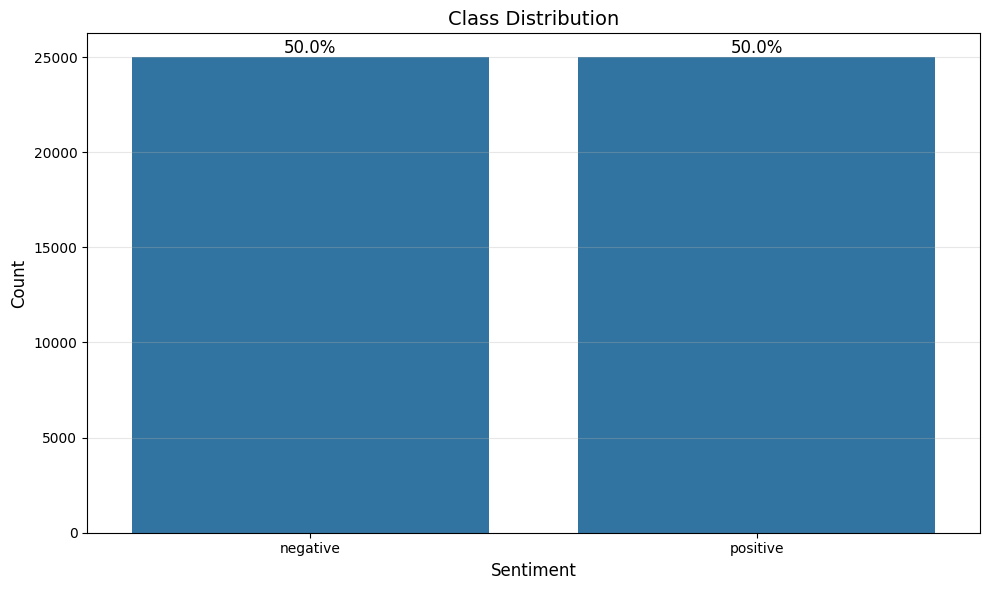

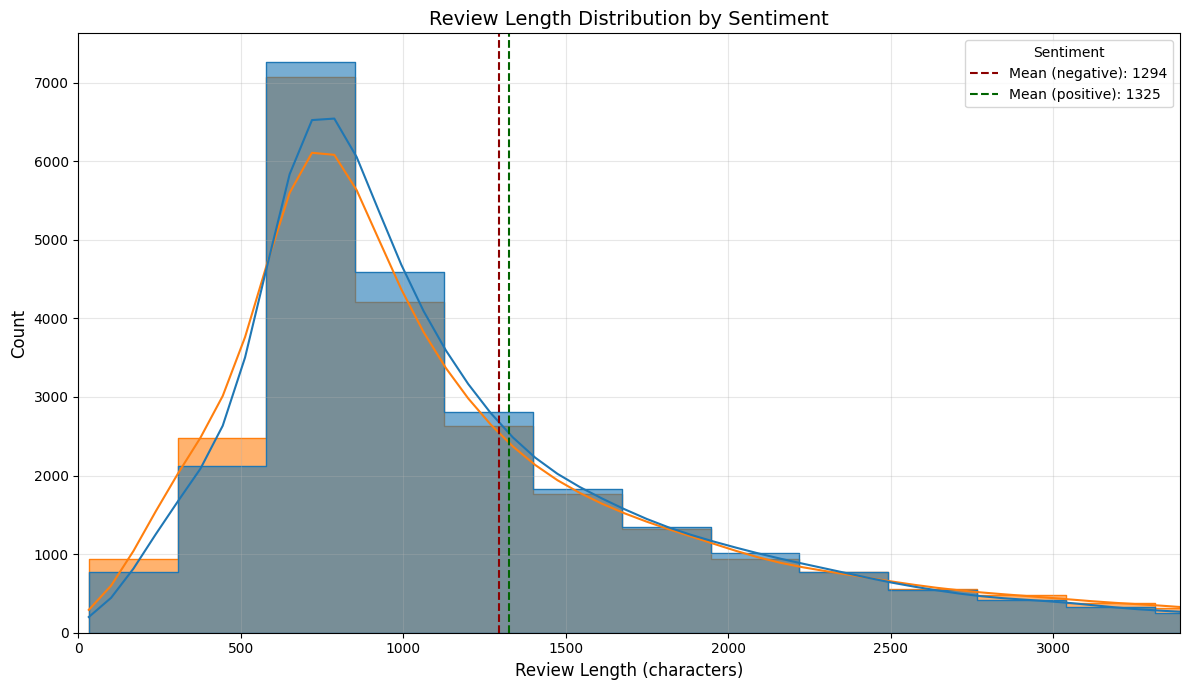

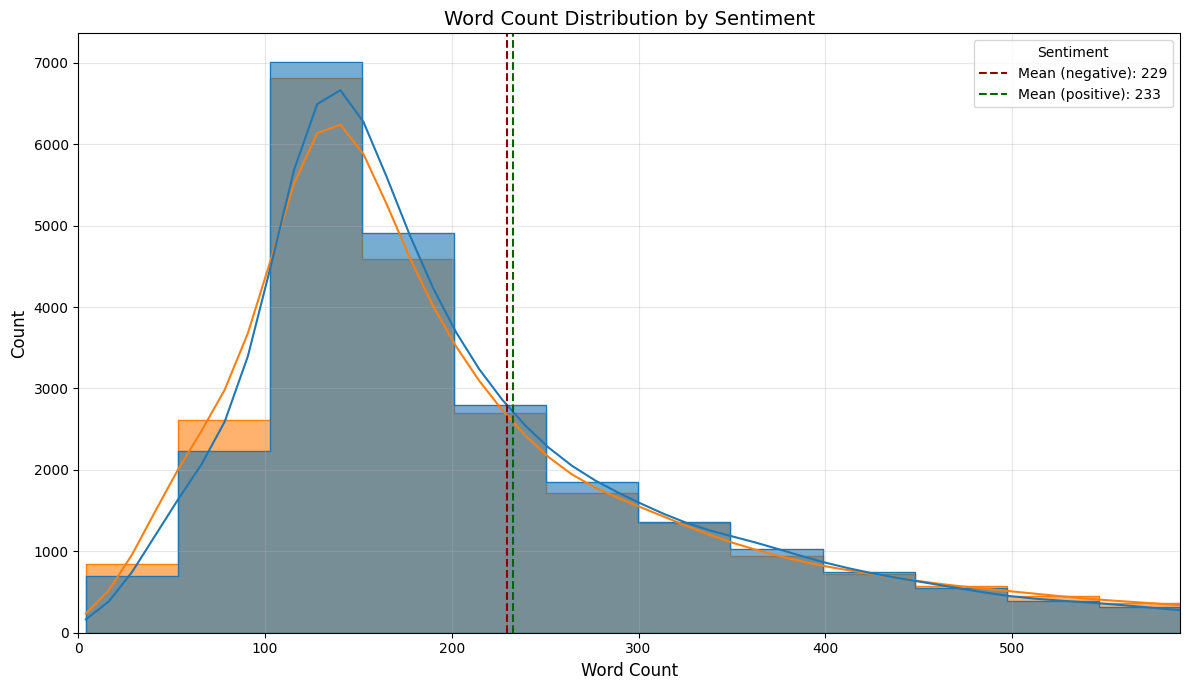

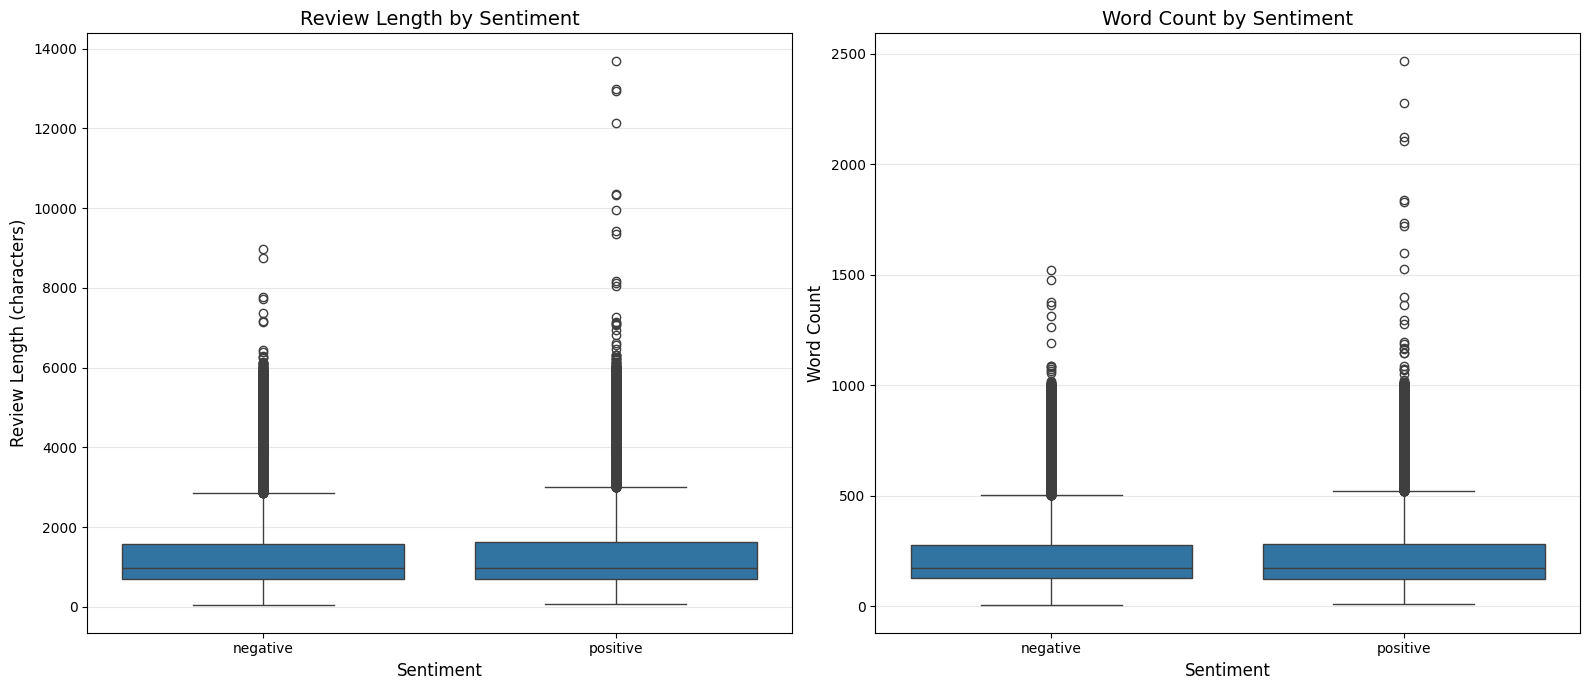

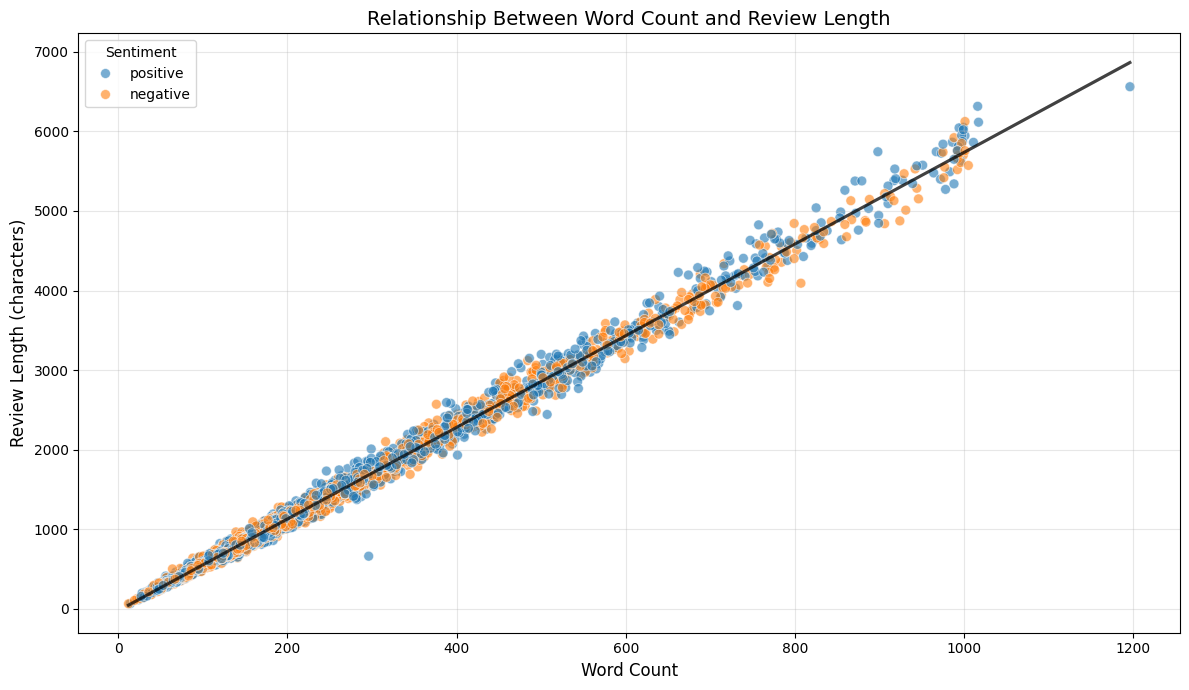

2025-05-27 22:50:43,181 - INFO - 
Preprocessing data...
2025-05-27 22:50:43,183 - INFO - Preprocessing data...
2025-05-27 22:50:45,683 - INFO - Processed 1/50000 reviews (0.0%)
2025-05-27 22:50:50,875 - INFO - Processed 2501/50000 reviews (5.0%)
2025-05-27 22:50:56,004 - INFO - Processed 5001/50000 reviews (10.0%)
2025-05-27 22:51:01,359 - INFO - Processed 7501/50000 reviews (15.0%)
2025-05-27 22:51:07,243 - INFO - Processed 10001/50000 reviews (20.0%)
2025-05-27 22:51:13,510 - INFO - Processed 12501/50000 reviews (25.0%)
2025-05-27 22:51:18,624 - INFO - Processed 15001/50000 reviews (30.0%)
2025-05-27 22:51:23,772 - INFO - Processed 17501/50000 reviews (35.0%)
2025-05-27 22:51:28,859 - INFO - Processed 20001/50000 reviews (40.0%)
2025-05-27 22:51:33,700 - INFO - Processed 22501/50000 reviews (45.0%)
2025-05-27 22:51:39,178 - INFO - Processed 25001/50000 reviews (50.0%)
2025-05-27 22:51:44,206 - INFO - Processed 27501/50000 reviews (55.0%)
2025-05-27 22:51:49,062 - INFO - Processed 300

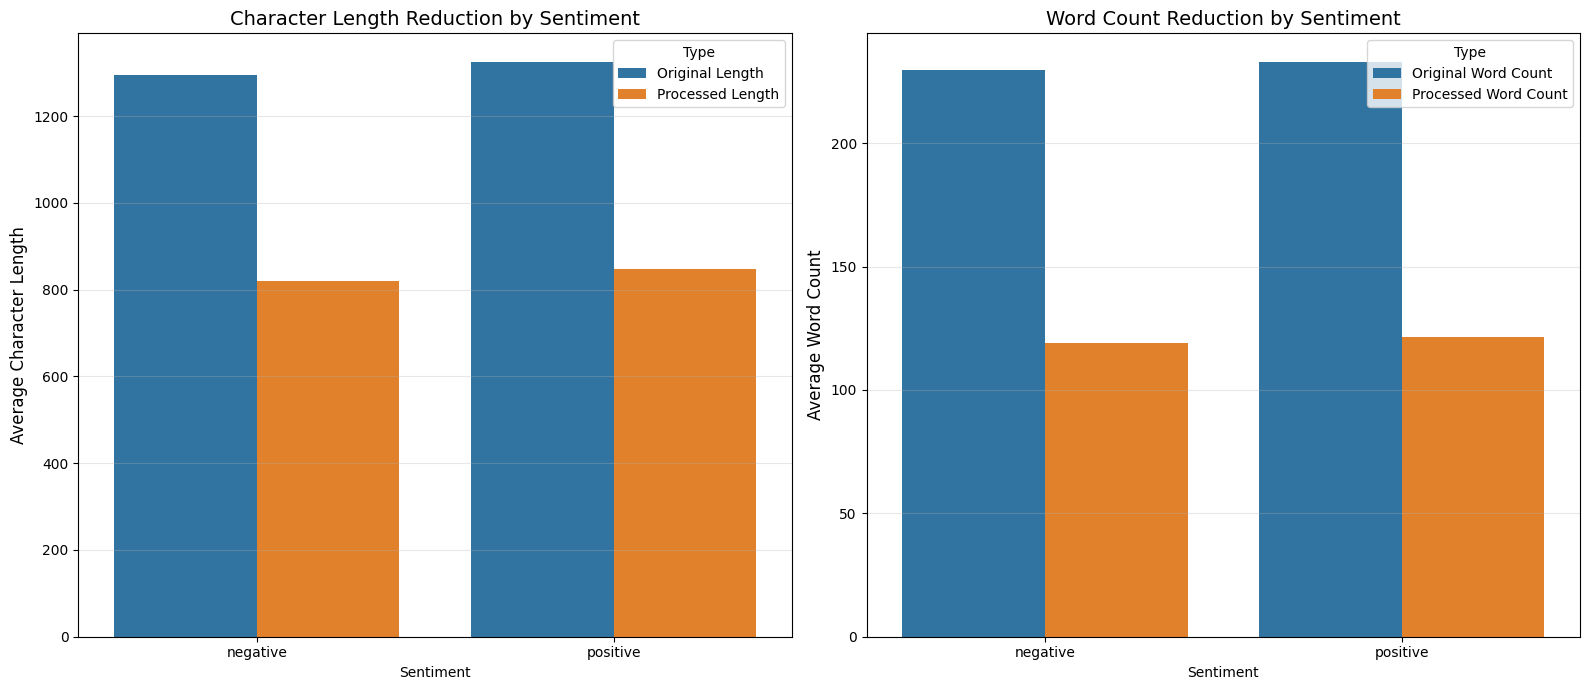

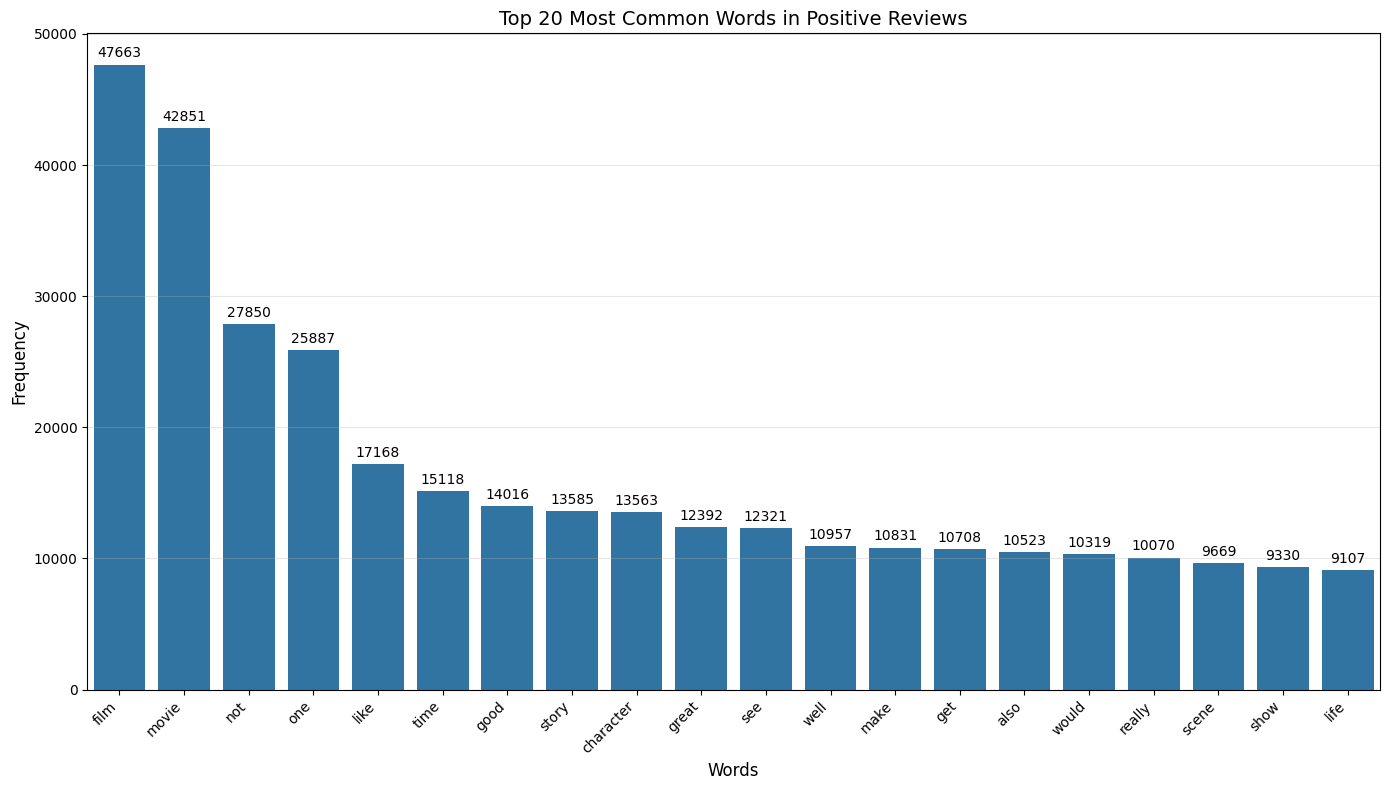

2025-05-27 22:52:31,277 - INFO - 
Top 20 words in positive reviews:
2025-05-27 22:52:31,278 - INFO - film: 47663
2025-05-27 22:52:31,280 - INFO - movie: 42851
2025-05-27 22:52:31,281 - INFO - not: 27850
2025-05-27 22:52:31,281 - INFO - one: 25887
2025-05-27 22:52:31,282 - INFO - like: 17168
2025-05-27 22:52:31,282 - INFO - time: 15118
2025-05-27 22:52:31,283 - INFO - good: 14016
2025-05-27 22:52:31,283 - INFO - story: 13585
2025-05-27 22:52:31,284 - INFO - character: 13563
2025-05-27 22:52:31,284 - INFO - great: 12392
2025-05-27 22:52:31,285 - INFO - see: 12321
2025-05-27 22:52:31,285 - INFO - well: 10957
2025-05-27 22:52:31,286 - INFO - make: 10831
2025-05-27 22:52:31,287 - INFO - get: 10708
2025-05-27 22:52:31,287 - INFO - also: 10523
2025-05-27 22:52:31,288 - INFO - would: 10319
2025-05-27 22:52:31,289 - INFO - really: 10070
2025-05-27 22:52:31,289 - INFO - scene: 9669
2025-05-27 22:52:31,290 - INFO - show: 9330
2025-05-27 22:52:31,290 - INFO - life: 9107


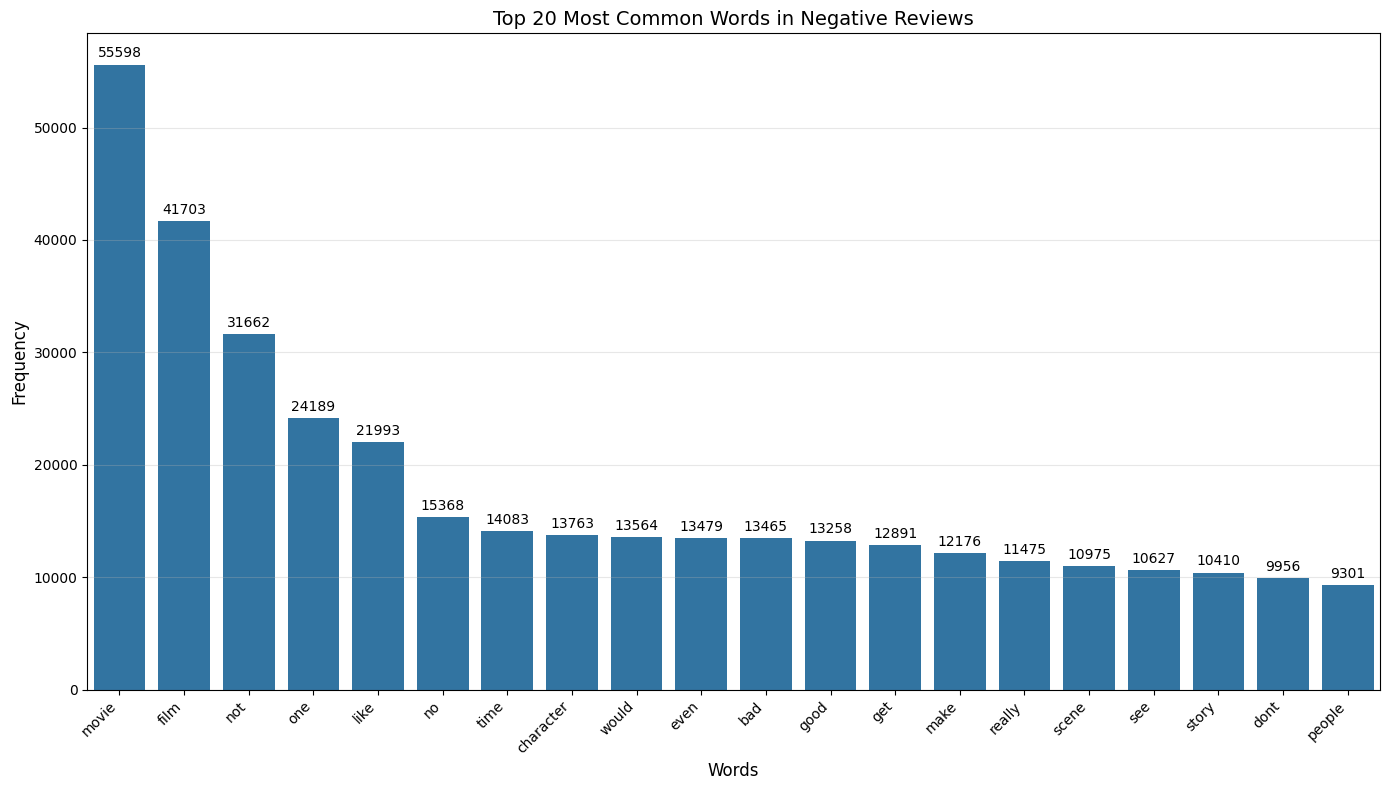

2025-05-27 22:52:32,086 - INFO - 
Top 20 words in negative reviews:
2025-05-27 22:52:32,087 - INFO - movie: 55598
2025-05-27 22:52:32,087 - INFO - film: 41703
2025-05-27 22:52:32,088 - INFO - not: 31662
2025-05-27 22:52:32,088 - INFO - one: 24189
2025-05-27 22:52:32,089 - INFO - like: 21993
2025-05-27 22:52:32,089 - INFO - no: 15368
2025-05-27 22:52:32,089 - INFO - time: 14083
2025-05-27 22:52:32,090 - INFO - character: 13763
2025-05-27 22:52:32,090 - INFO - would: 13564
2025-05-27 22:52:32,091 - INFO - even: 13479
2025-05-27 22:52:32,091 - INFO - bad: 13465
2025-05-27 22:52:32,092 - INFO - good: 13258
2025-05-27 22:52:32,094 - INFO - get: 12891
2025-05-27 22:52:32,094 - INFO - make: 12176
2025-05-27 22:52:32,095 - INFO - really: 11475
2025-05-27 22:52:32,096 - INFO - scene: 10975
2025-05-27 22:52:32,096 - INFO - see: 10627
2025-05-27 22:52:32,096 - INFO - story: 10410
2025-05-27 22:52:32,097 - INFO - dont: 9956
2025-05-27 22:52:32,097 - INFO - people: 9301


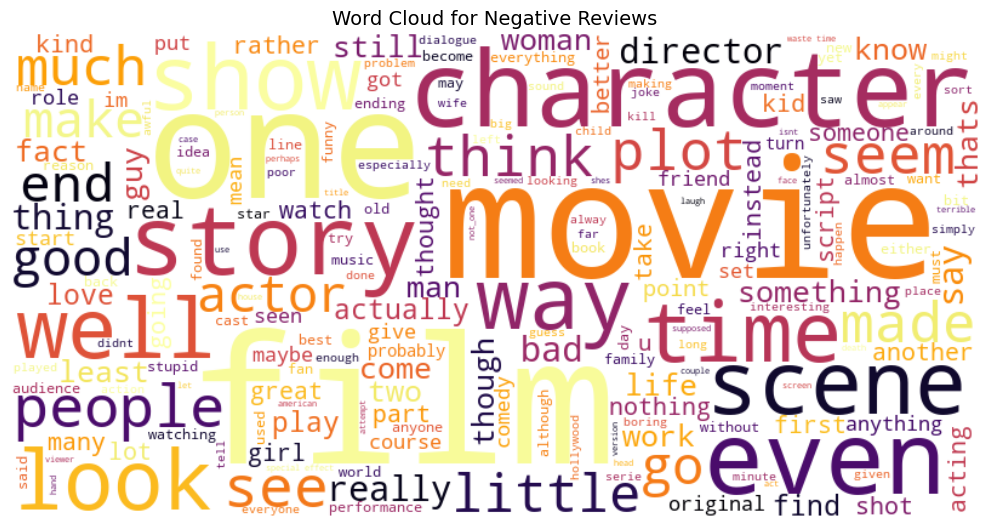

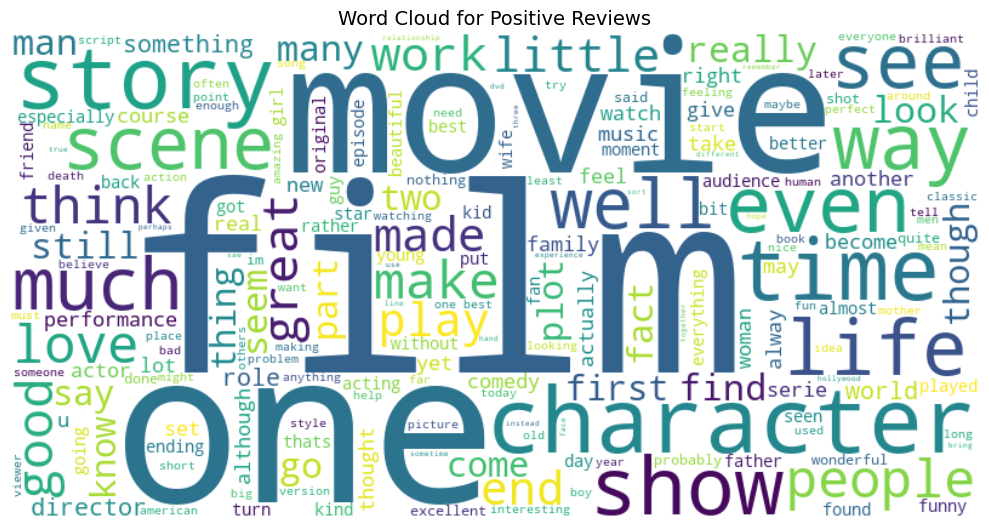

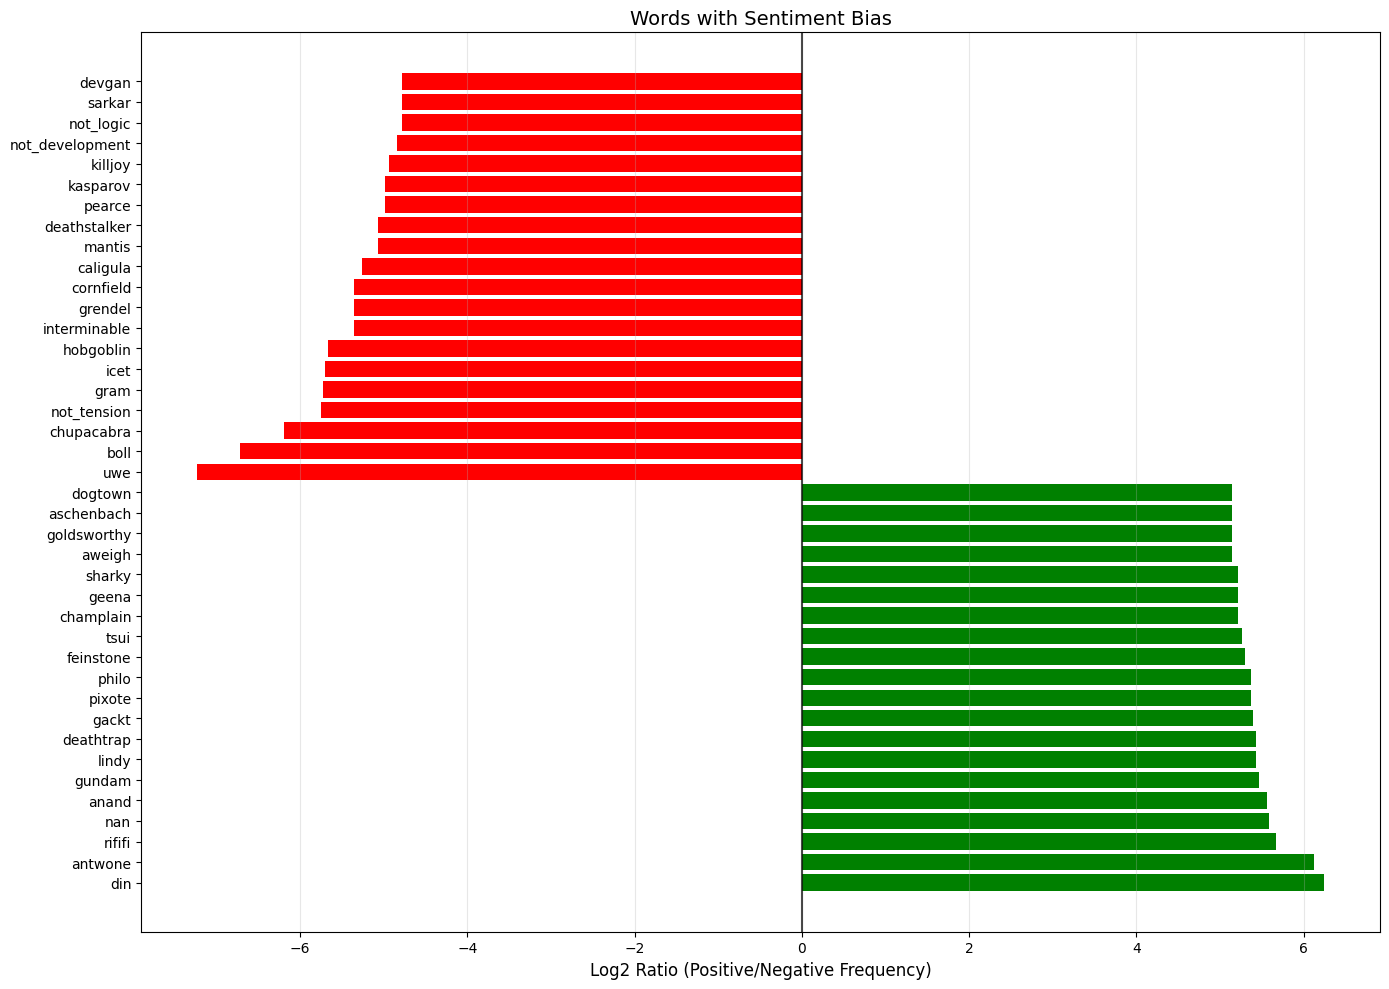

2025-05-27 22:53:04,127 - INFO - 
Top words biased towards positive sentiment:
2025-05-27 22:53:04,128 - INFO - din: 6.2395 (2^6.24 = 75.56x more common in positive)
2025-05-27 22:53:04,129 - INFO - antwone: 6.1225 (2^6.12 = 69.67x more common in positive)
2025-05-27 22:53:04,129 - INFO - rififi: 5.6732 (2^5.67 = 51.03x more common in positive)
2025-05-27 22:53:04,130 - INFO - nan: 5.5875 (2^5.59 = 48.08x more common in positive)
2025-05-27 22:53:04,130 - INFO - anand: 5.5577 (2^5.56 = 47.10x more common in positive)
2025-05-27 22:53:04,131 - INFO - gundam: 5.4646 (2^5.46 = 44.16x more common in positive)
2025-05-27 22:53:04,131 - INFO - lindy: 5.4322 (2^5.43 = 43.18x more common in positive)
2025-05-27 22:53:04,132 - INFO - deathtrap: 5.4322 (2^5.43 = 43.18x more common in positive)
2025-05-27 22:53:04,132 - INFO - gackt: 5.3990 (2^5.40 = 42.20x more common in positive)
2025-05-27 22:53:04,132 - INFO - pixote: 5.3651 (2^5.37 = 41.21x more common in positive)
2025-05-27 22:53:04,133 - 

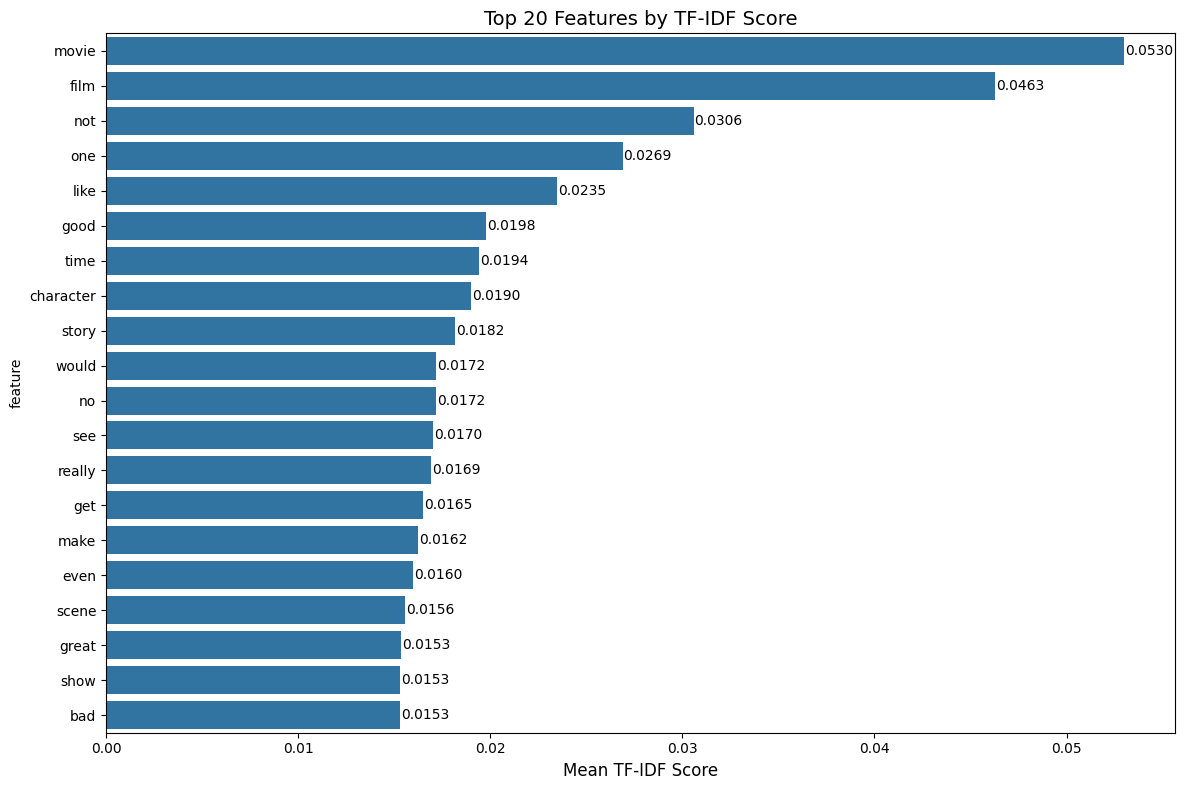

2025-05-27 22:53:53,709 - INFO - 
Top 20 features by TF-IDF score:
2025-05-27 22:53:53,710 - INFO - movie: 0.0530
2025-05-27 22:53:53,710 - INFO - film: 0.0463
2025-05-27 22:53:53,711 - INFO - not: 0.0306
2025-05-27 22:53:53,712 - INFO - one: 0.0269
2025-05-27 22:53:53,713 - INFO - like: 0.0235
2025-05-27 22:53:53,713 - INFO - good: 0.0198
2025-05-27 22:53:53,715 - INFO - time: 0.0194
2025-05-27 22:53:53,716 - INFO - character: 0.0190
2025-05-27 22:53:53,717 - INFO - story: 0.0182
2025-05-27 22:53:53,717 - INFO - would: 0.0172
2025-05-27 22:53:53,719 - INFO - no: 0.0172
2025-05-27 22:53:53,721 - INFO - see: 0.0170
2025-05-27 22:53:53,722 - INFO - really: 0.0169
2025-05-27 22:53:53,723 - INFO - get: 0.0165
2025-05-27 22:53:53,724 - INFO - make: 0.0162
2025-05-27 22:53:53,726 - INFO - even: 0.0160
2025-05-27 22:53:53,727 - INFO - scene: 0.0156
2025-05-27 22:53:53,728 - INFO - great: 0.0153
2025-05-27 22:53:53,729 - INFO - show: 0.0153
2025-05-27 22:53:53,730 - INFO - bad: 0.0153
2025-05-

<Figure size 1400x1000 with 0 Axes>

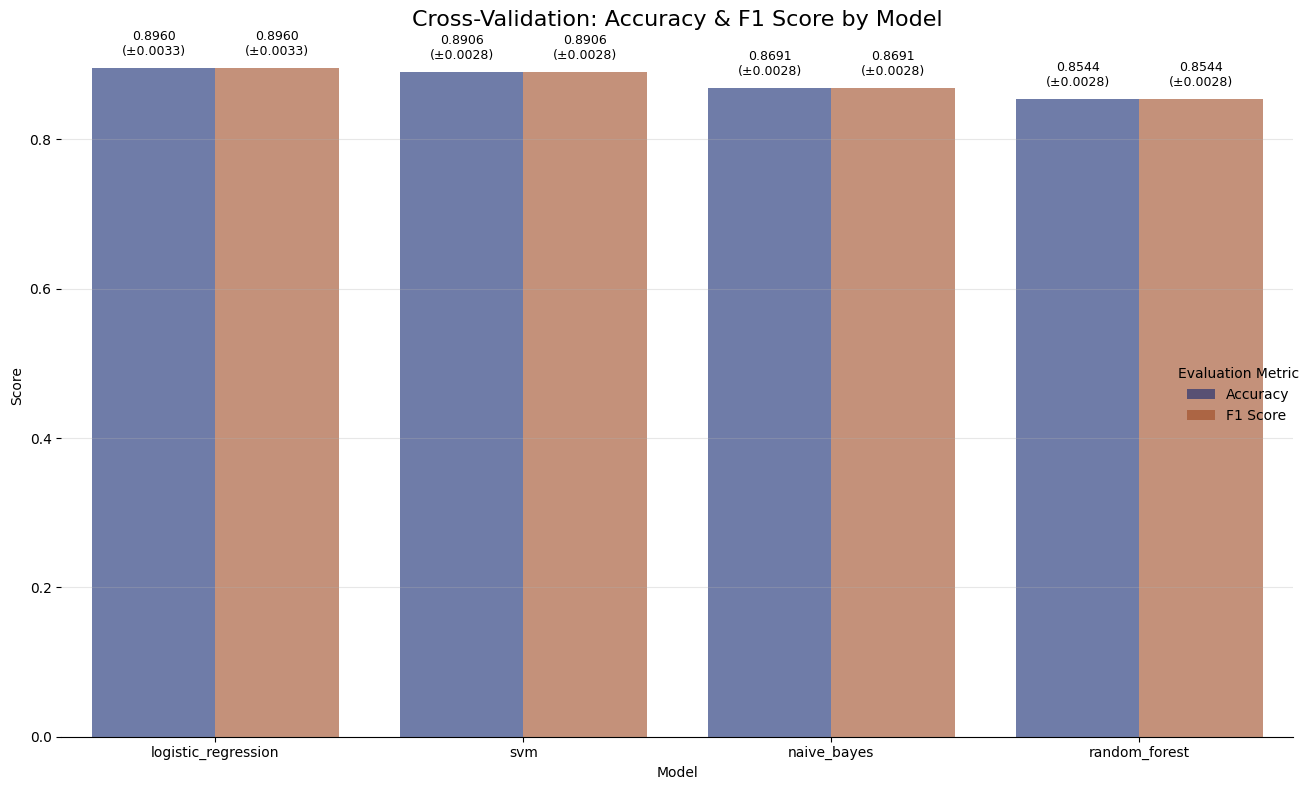

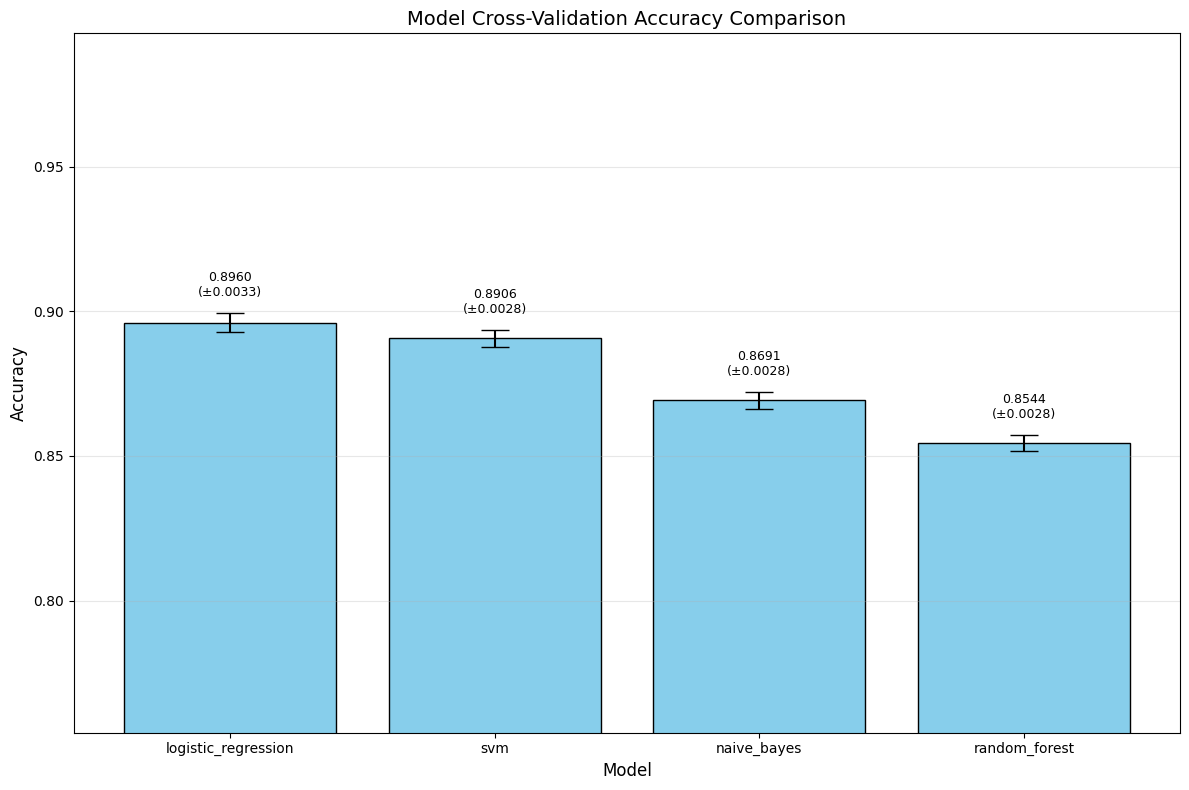

2025-05-27 23:12:40,177 - INFO - 
Training best model (logistic_regression) from CV on full dataset (X,y)...
2025-05-27 23:12:40,449 - INFO - Best model based on CV F1 Score: logistic_regression with mean F1: 0.8960
2025-05-27 23:12:40,450 - INFO - 
Splitting data into train and test sets...
2025-05-27 23:12:40,450 - INFO - Splitting data into train and test sets with test_size=0.2...
2025-05-27 23:12:40,482 - INFO - Train set size: 40000
2025-05-27 23:12:40,483 - INFO - Test set size: 10000
2025-05-27 23:12:40,483 - INFO - 
Extracting features...
2025-05-27 23:12:40,484 - INFO - Extracting features using tfidf vectorization with 10000 max features...
2025-05-27 23:13:17,538 - INFO - Vocabulary size: 10000
2025-05-27 23:13:17,539 - INFO - Training set shape: (40000, 10000)
2025-05-27 23:13:17,539 - INFO - Test set shape: (10000, 10000)
2025-05-27 23:13:17,540 - INFO - Feature extraction completed in 37.06 seconds


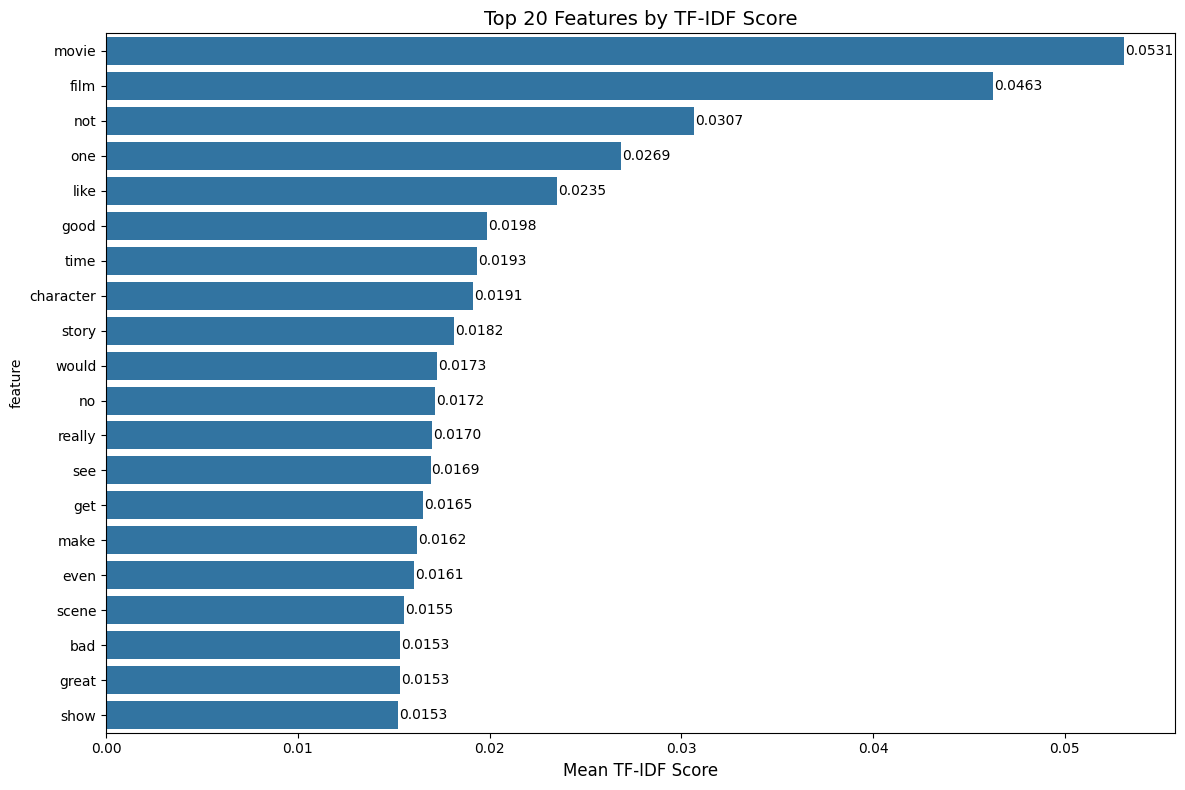

2025-05-27 23:13:17,772 - INFO - 
Top 20 features by TF-IDF score:
2025-05-27 23:13:17,774 - INFO - movie: 0.0531
2025-05-27 23:13:17,775 - INFO - film: 0.0463
2025-05-27 23:13:17,776 - INFO - not: 0.0307
2025-05-27 23:13:17,777 - INFO - one: 0.0269
2025-05-27 23:13:17,778 - INFO - like: 0.0235
2025-05-27 23:13:17,779 - INFO - good: 0.0198
2025-05-27 23:13:17,781 - INFO - time: 0.0193
2025-05-27 23:13:17,783 - INFO - character: 0.0191
2025-05-27 23:13:17,784 - INFO - story: 0.0182
2025-05-27 23:13:17,784 - INFO - would: 0.0173
2025-05-27 23:13:17,785 - INFO - no: 0.0172
2025-05-27 23:13:17,786 - INFO - really: 0.0170
2025-05-27 23:13:17,787 - INFO - see: 0.0169
2025-05-27 23:13:17,788 - INFO - get: 0.0165
2025-05-27 23:13:17,790 - INFO - make: 0.0162
2025-05-27 23:13:17,792 - INFO - even: 0.0161
2025-05-27 23:13:17,793 - INFO - scene: 0.0155
2025-05-27 23:13:17,793 - INFO - bad: 0.0153
2025-05-27 23:13:17,794 - INFO - great: 0.0153
2025-05-27 23:13:17,794 - INFO - show: 0.0153
2025-05-

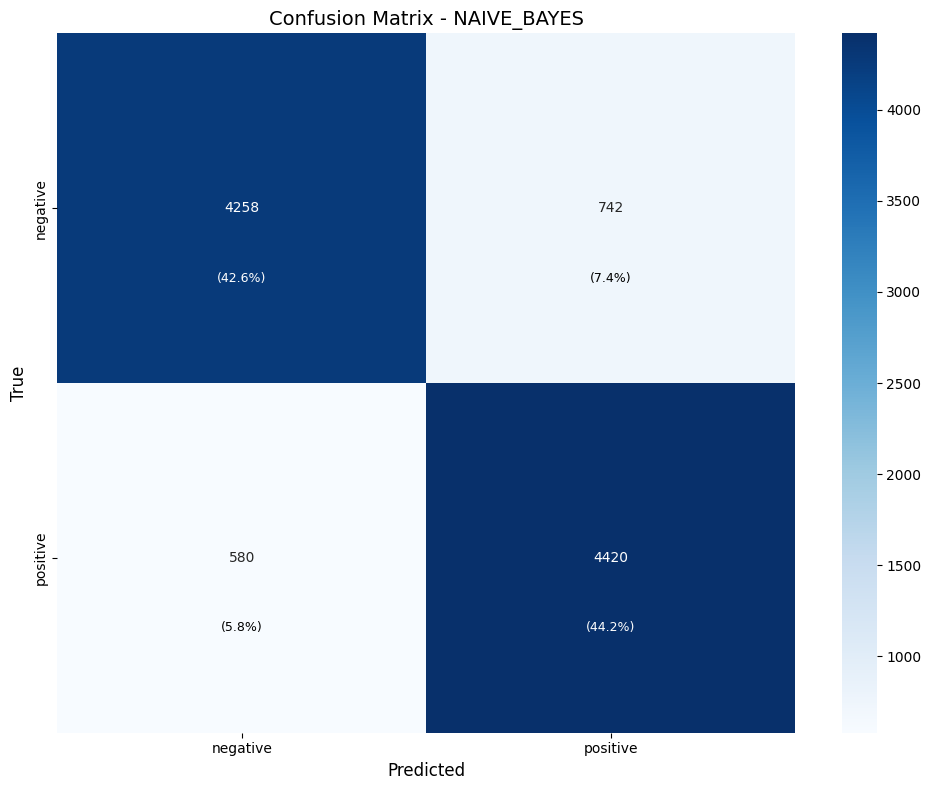

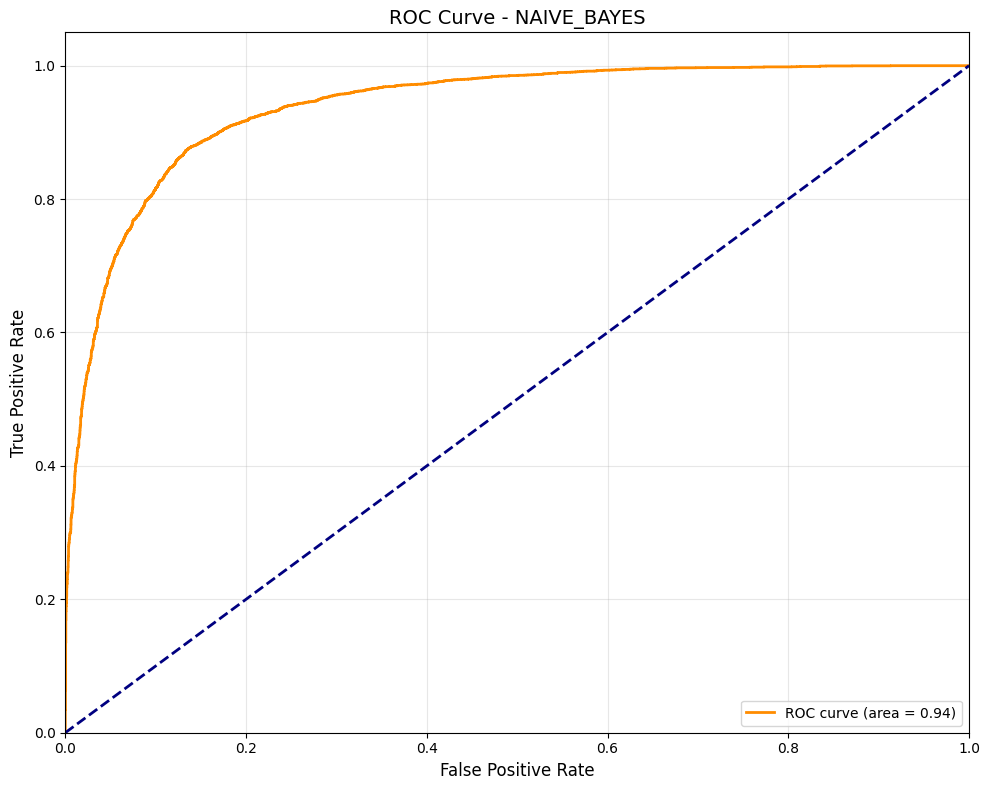

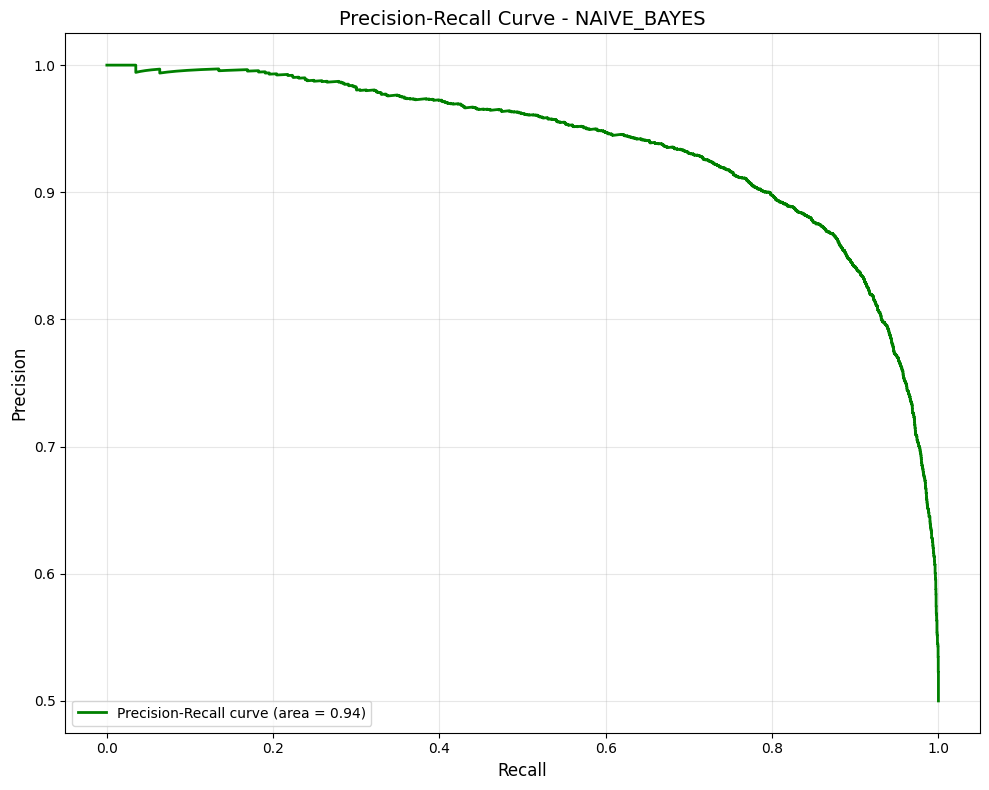

2025-05-27 23:13:18,486 - INFO - 
Misclassification Analysis for naive_bayes:
2025-05-27 23:13:18,488 - INFO - Total misclassified samples: 1322 (13.22%)
2025-05-27 23:13:18,498 - INFO - Class 'negative': 742/5000 misclassified (14.84%)
2025-05-27 23:13:18,499 - INFO - Class 'positive': 580/5000 misclassified (11.60%)
2025-05-27 23:13:18,500 - INFO - Training logistic_regression model...
2025-05-27 23:13:18,777 - INFO - Model training completed in 0.28 seconds
2025-05-27 23:13:18,779 - INFO - Evaluating logistic_regression model...
2025-05-27 23:13:18,909 - INFO - 
LOGISTIC_REGRESSION Model Evaluation:
2025-05-27 23:13:18,911 - INFO - Accuracy: 0.8938
2025-05-27 23:13:18,911 - INFO - F1 Score: 0.8938
2025-05-27 23:13:18,911 - INFO - 
Classification Report:
2025-05-27 23:13:18,912 - INFO -               precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.88      0.91      0.90      5000

    accuracy                        

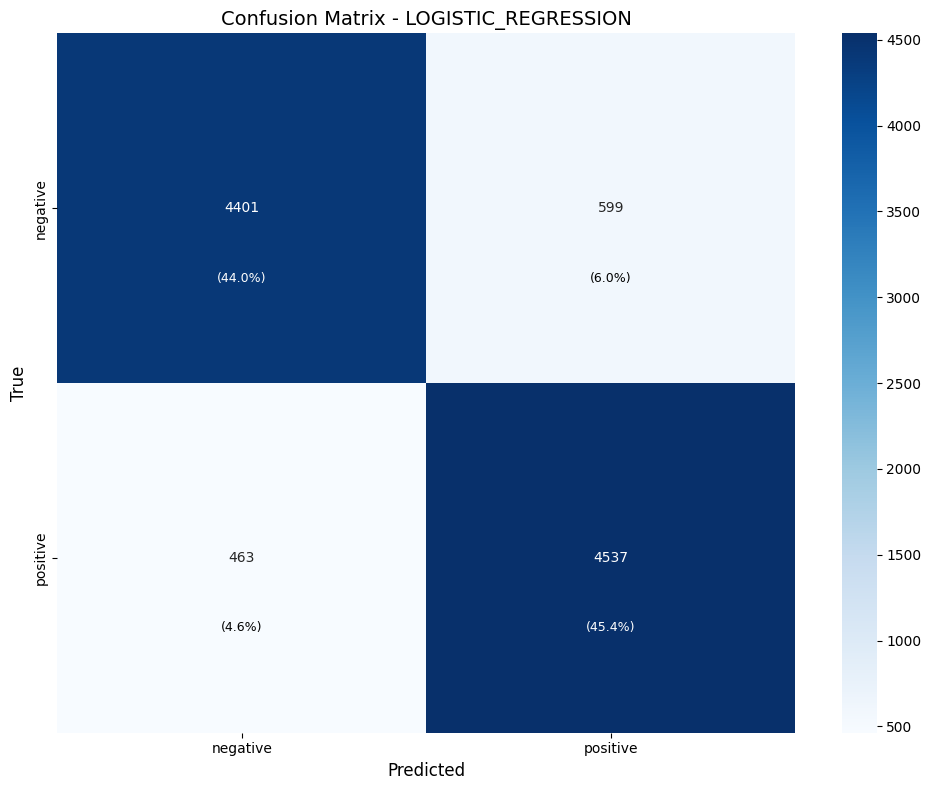

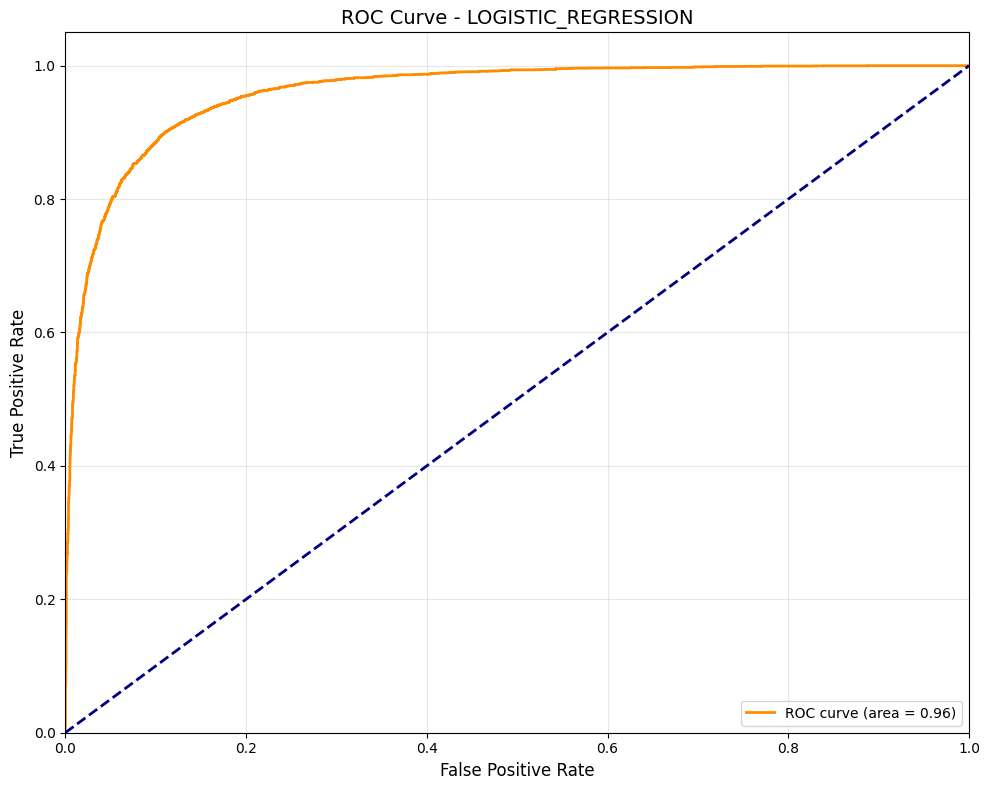

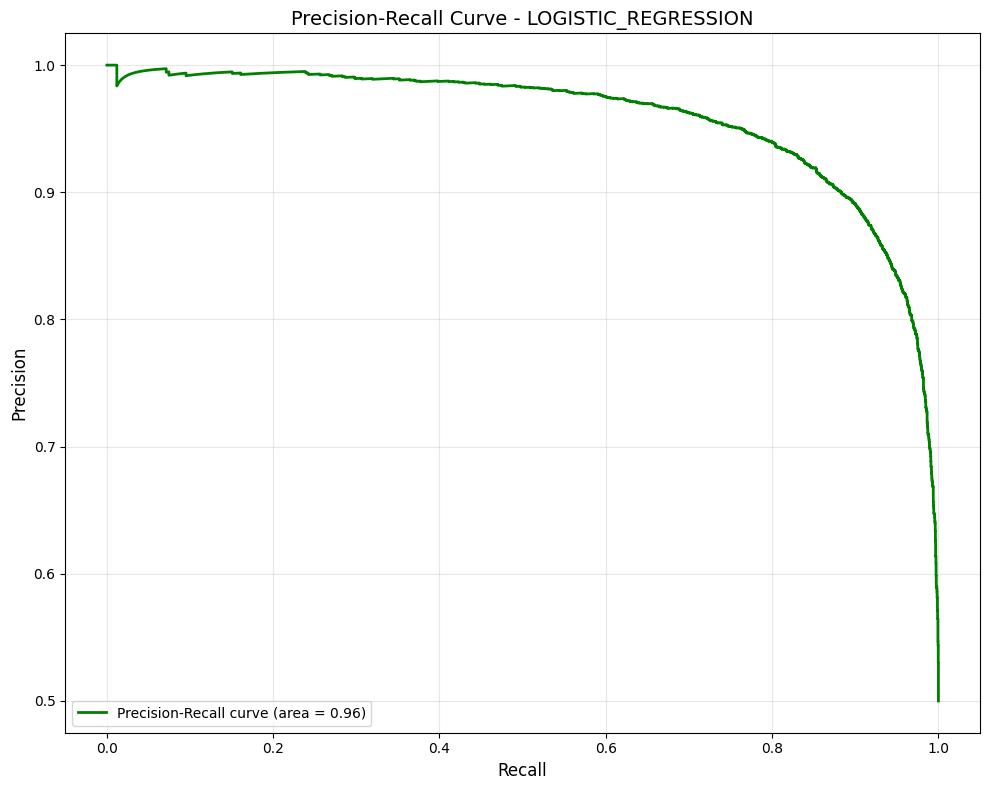

2025-05-27 23:13:19,444 - INFO - 
Misclassification Analysis for logistic_regression:
2025-05-27 23:13:19,446 - INFO - Total misclassified samples: 1062 (10.62%)
2025-05-27 23:13:19,452 - INFO - Class 'negative': 599/5000 misclassified (11.98%)
2025-05-27 23:13:19,454 - INFO - Class 'positive': 463/5000 misclassified (9.26%)
2025-05-27 23:13:19,455 - INFO - Training svm model...
2025-05-27 23:13:20,416 - INFO - Model training completed in 0.96 seconds
2025-05-27 23:13:20,416 - INFO - Evaluating svm model...
2025-05-27 23:13:20,538 - INFO - 
SVM Model Evaluation:
2025-05-27 23:13:20,539 - INFO - Accuracy: 0.8861
2025-05-27 23:13:20,540 - INFO - F1 Score: 0.8861
2025-05-27 23:13:20,540 - INFO - 
Classification Report:
2025-05-27 23:13:20,541 - INFO -               precision    recall  f1-score   support

    negative       0.89      0.88      0.88      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89

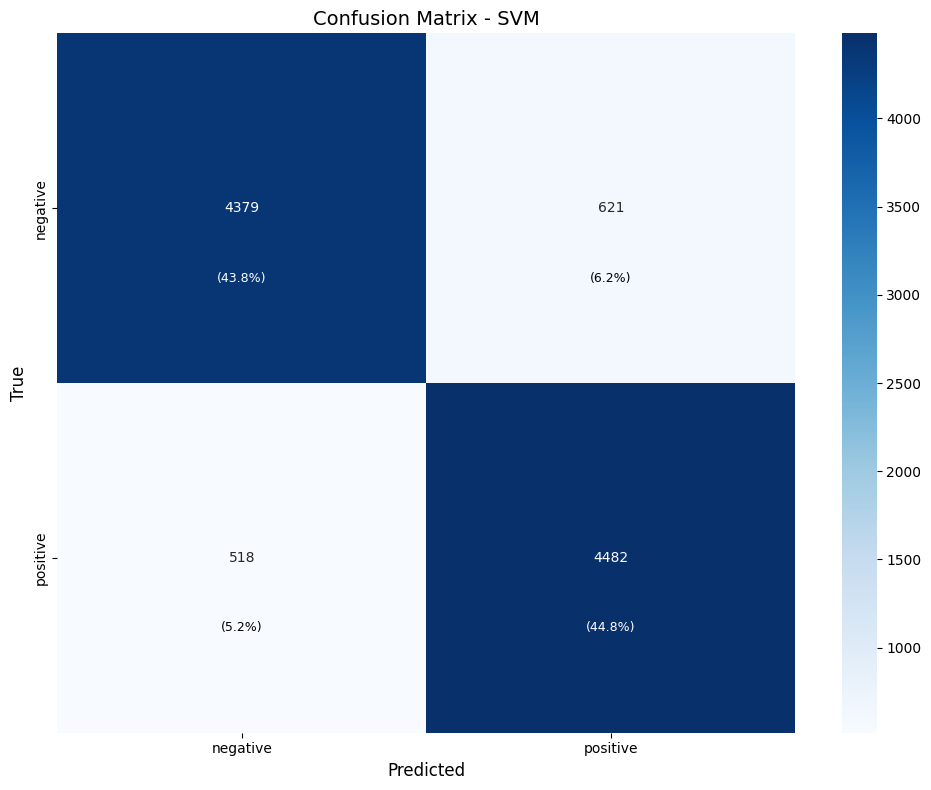

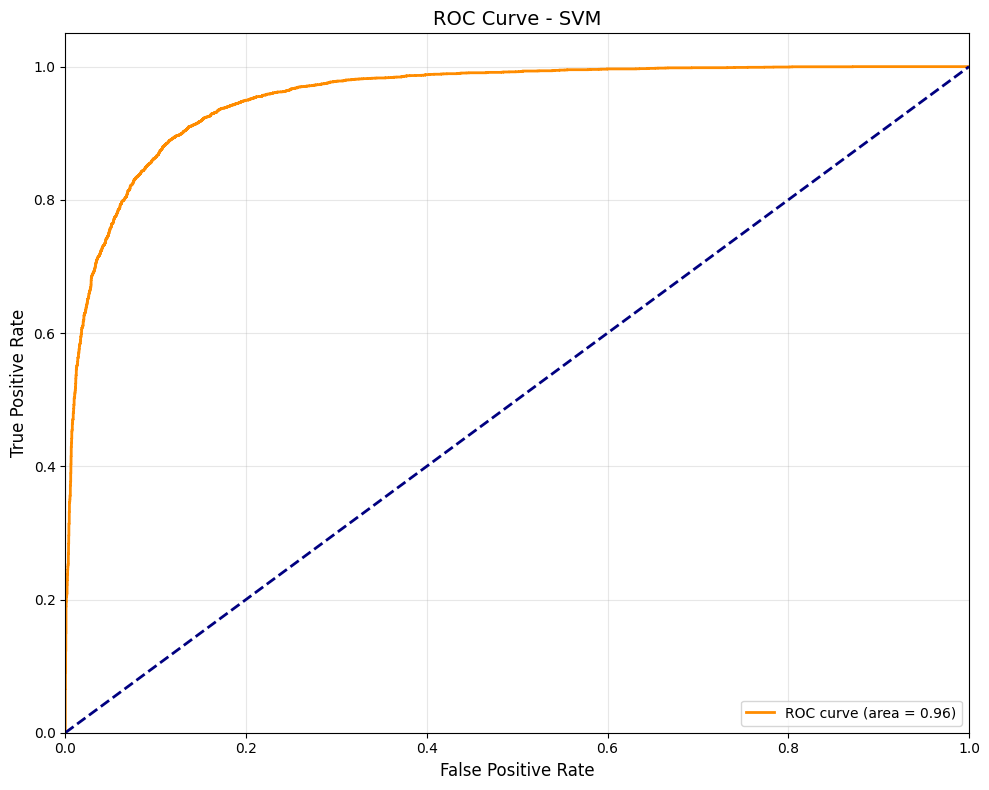

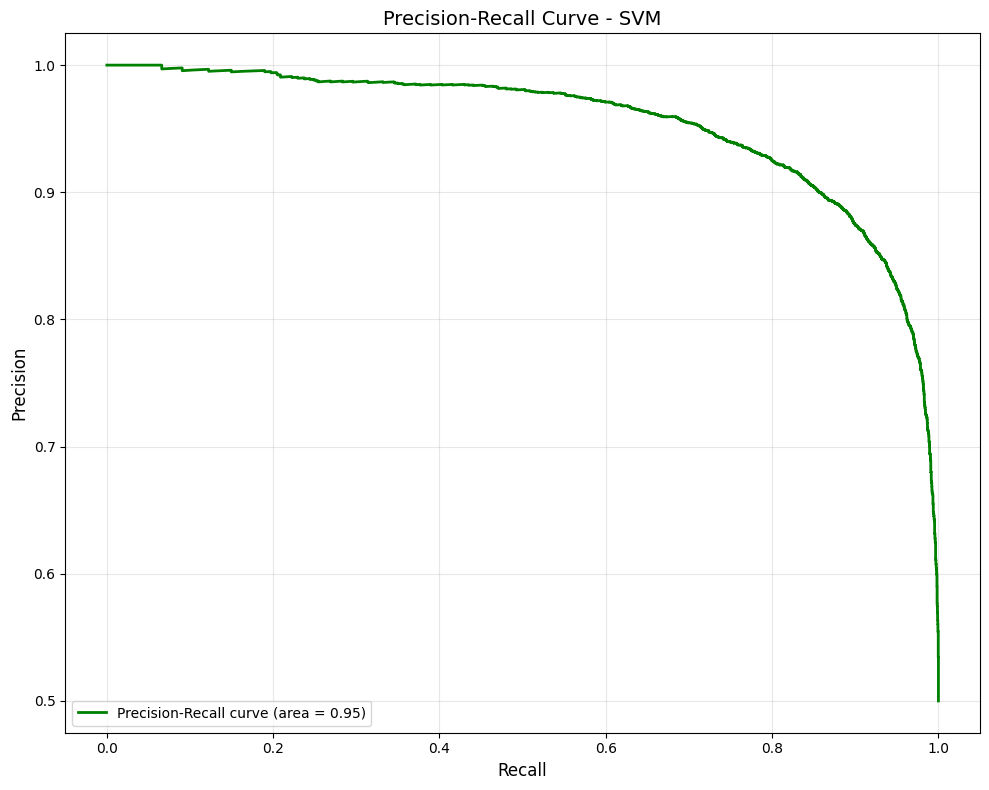

2025-05-27 23:13:20,952 - INFO - 
Misclassification Analysis for svm:
2025-05-27 23:13:20,952 - INFO - Total misclassified samples: 1139 (11.39%)
2025-05-27 23:13:20,955 - INFO - Class 'negative': 621/5000 misclassified (12.42%)
2025-05-27 23:13:20,956 - INFO - Class 'positive': 518/5000 misclassified (10.36%)
2025-05-27 23:13:20,957 - INFO - Training random_forest model...
2025-05-27 23:15:17,547 - INFO - Model training completed in 116.59 seconds
2025-05-27 23:15:17,548 - INFO - Evaluating random_forest model...
2025-05-27 23:15:18,676 - INFO - 
RANDOM_FOREST Model Evaluation:
2025-05-27 23:15:18,677 - INFO - Accuracy: 0.8523
2025-05-27 23:15:18,678 - INFO - F1 Score: 0.8523
2025-05-27 23:15:18,679 - INFO - 
Classification Report:
2025-05-27 23:15:18,679 - INFO -               precision    recall  f1-score   support

    negative       0.85      0.86      0.85      5000
    positive       0.86      0.85      0.85      5000

    accuracy                           0.85     10000
   mac

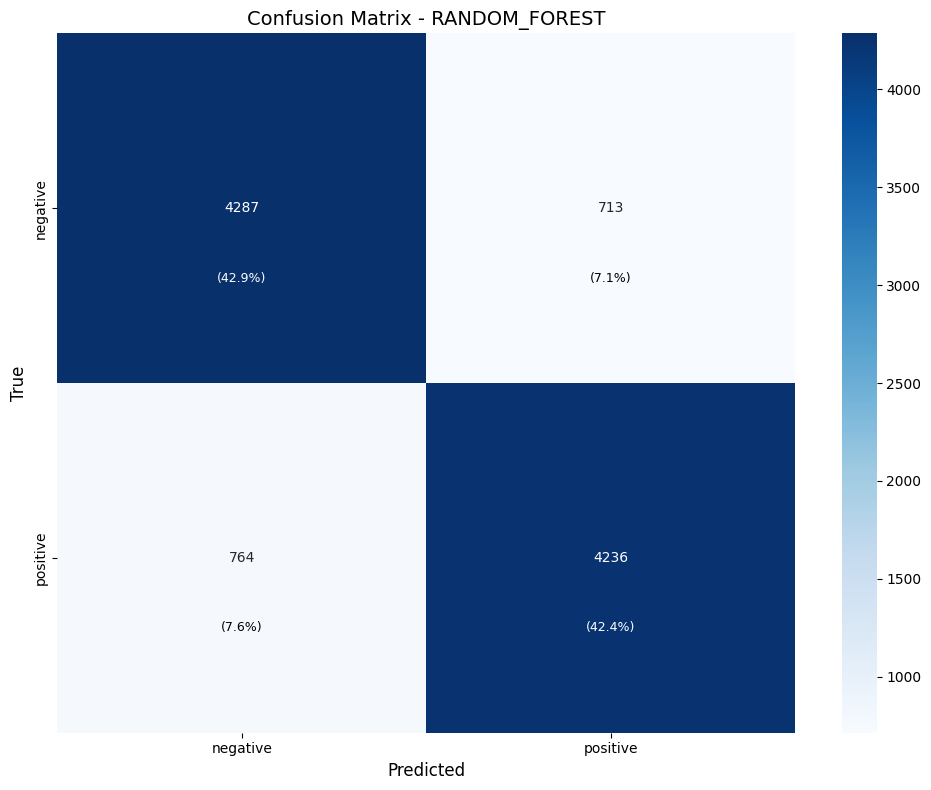

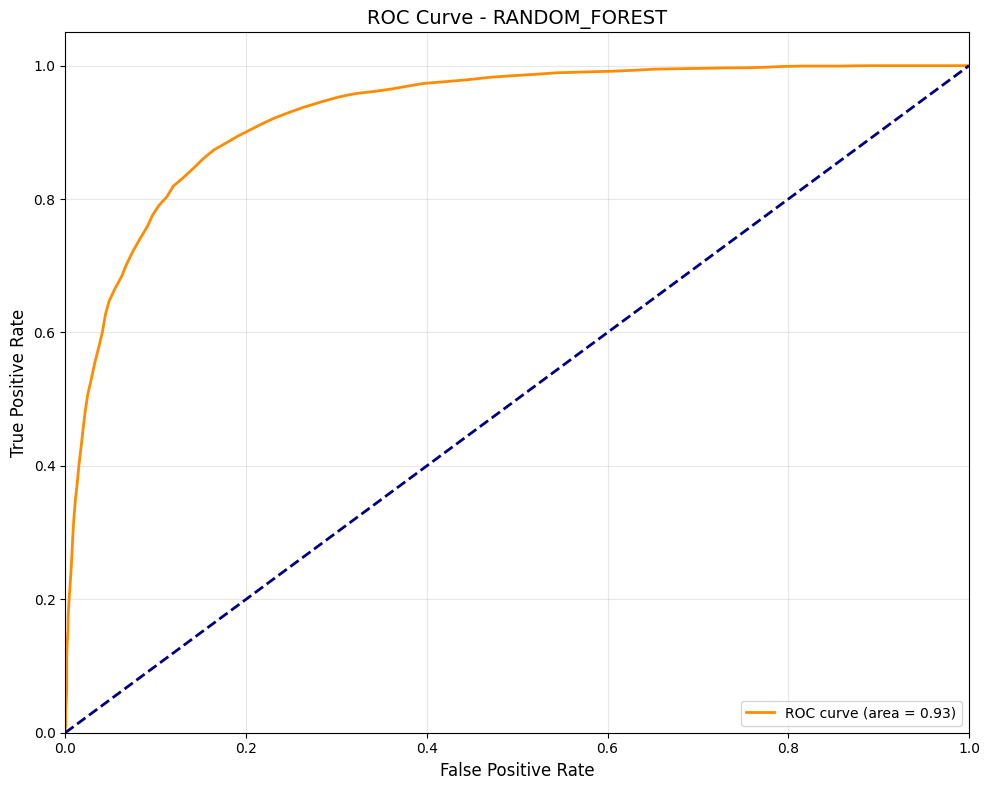

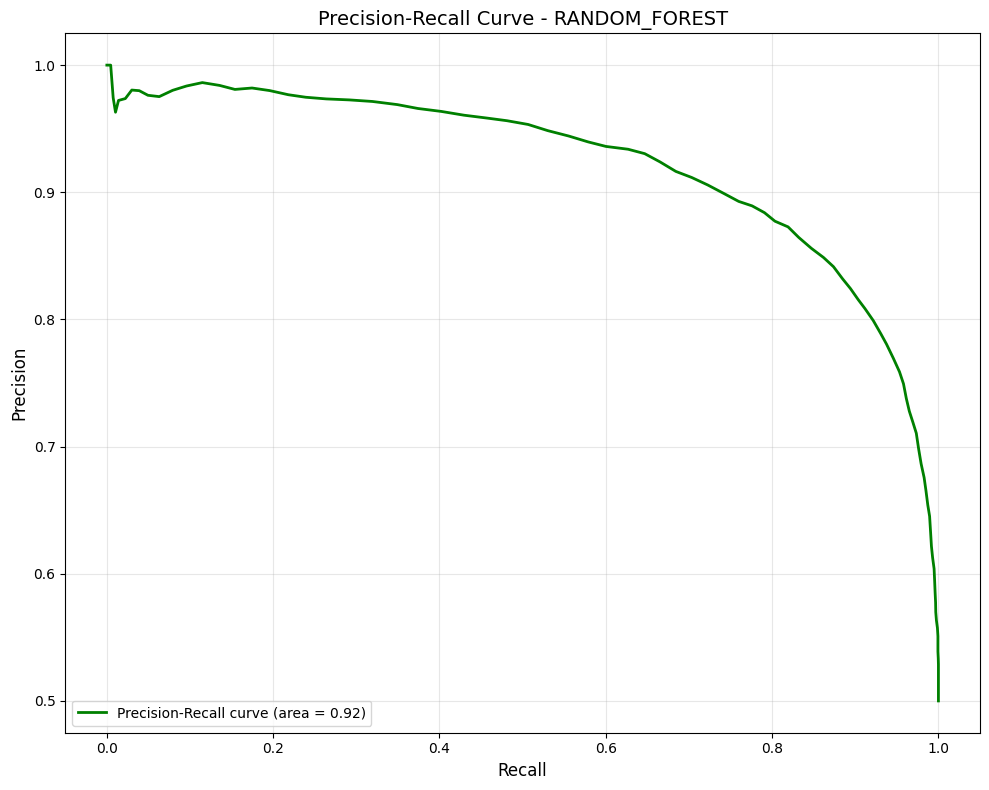

2025-05-27 23:15:19,118 - INFO - 
Misclassification Analysis for random_forest:
2025-05-27 23:15:19,119 - INFO - Total misclassified samples: 1477 (14.77%)
2025-05-27 23:15:19,124 - INFO - Class 'negative': 713/5000 misclassified (14.26%)
2025-05-27 23:15:19,125 - INFO - Class 'positive': 764/5000 misclassified (15.28%)
2025-05-27 23:15:19,125 - INFO - 
Performing hyperparameter tuning for Logistic Regression...
2025-05-27 23:15:19,126 - INFO - Performing hyperparameter tuning for logistic_regression...


Fitting 3 folds for each of 42 candidates, totalling 126 fits


2025-05-27 23:15:58,135 - INFO - Hyperparameter tuning completed in 39.01 seconds
2025-05-27 23:15:58,136 - INFO - Best parameters: {'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
2025-05-27 23:15:58,136 - INFO - Best cross-validation score: 0.8920


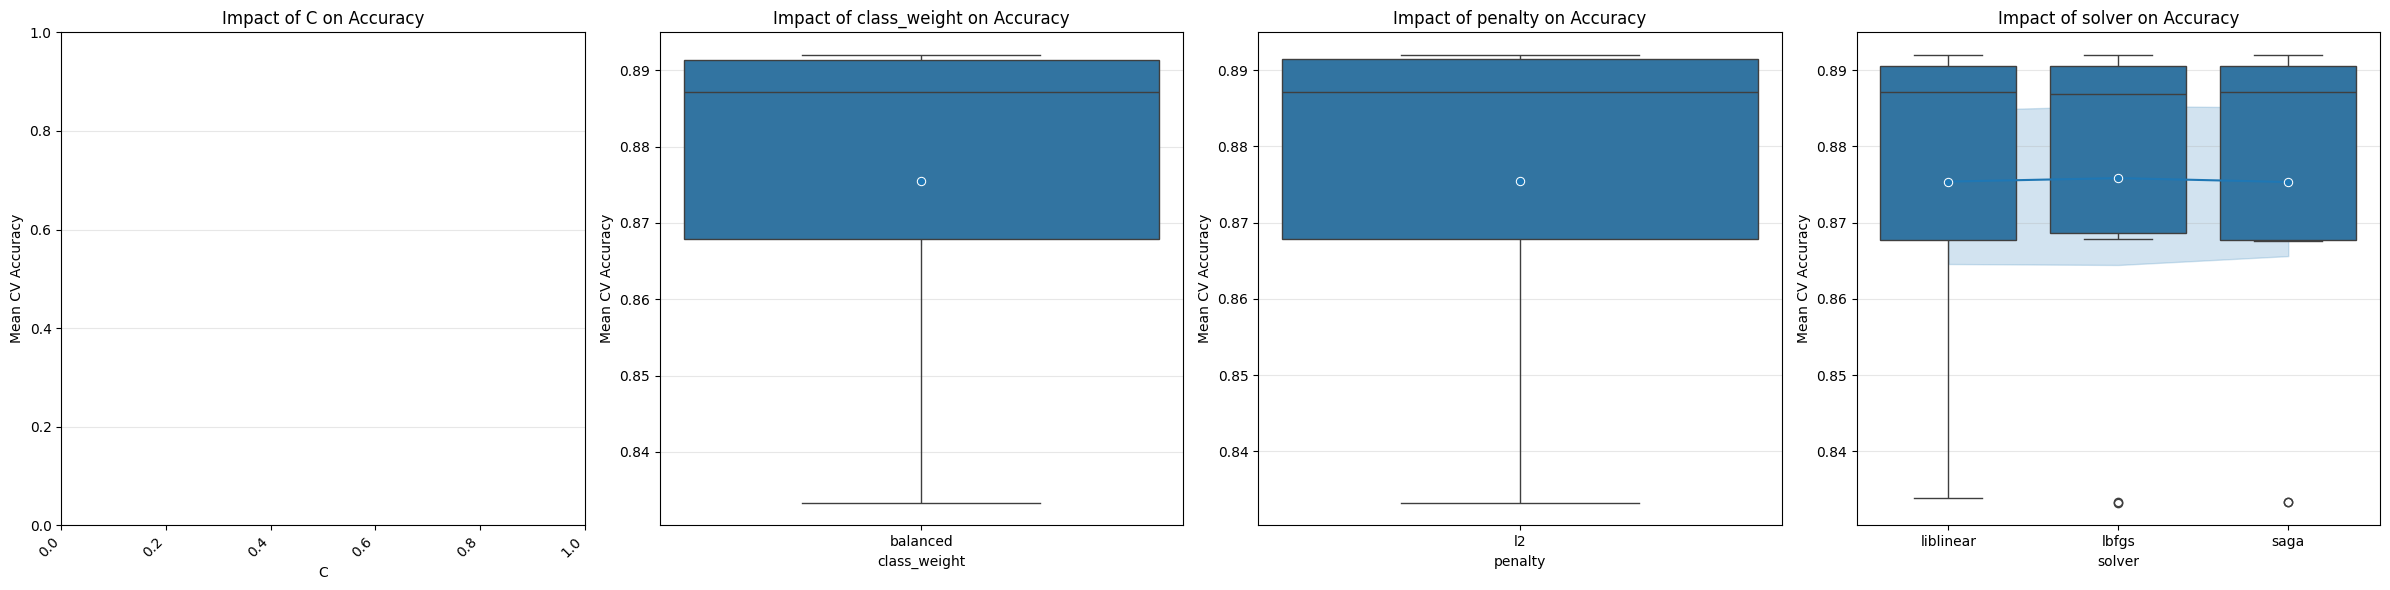

2025-05-27 23:15:58,610 - INFO - Tuned Logistic Regression - Best CV Score: 0.8920
2025-05-27 23:15:58,611 - INFO - Tuned Logistic Regression - Best Params: {'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
2025-05-27 23:15:58,611 - INFO - Evaluating logistic_regression_tuned model...
2025-05-27 23:15:58,748 - INFO - 
LOGISTIC_REGRESSION_TUNED Model Evaluation:
2025-05-27 23:15:58,749 - INFO - Accuracy: 0.8938
2025-05-27 23:15:58,750 - INFO - F1 Score: 0.8938
2025-05-27 23:15:58,750 - INFO - 
Classification Report:
2025-05-27 23:15:58,751 - INFO -               precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.88      0.91      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



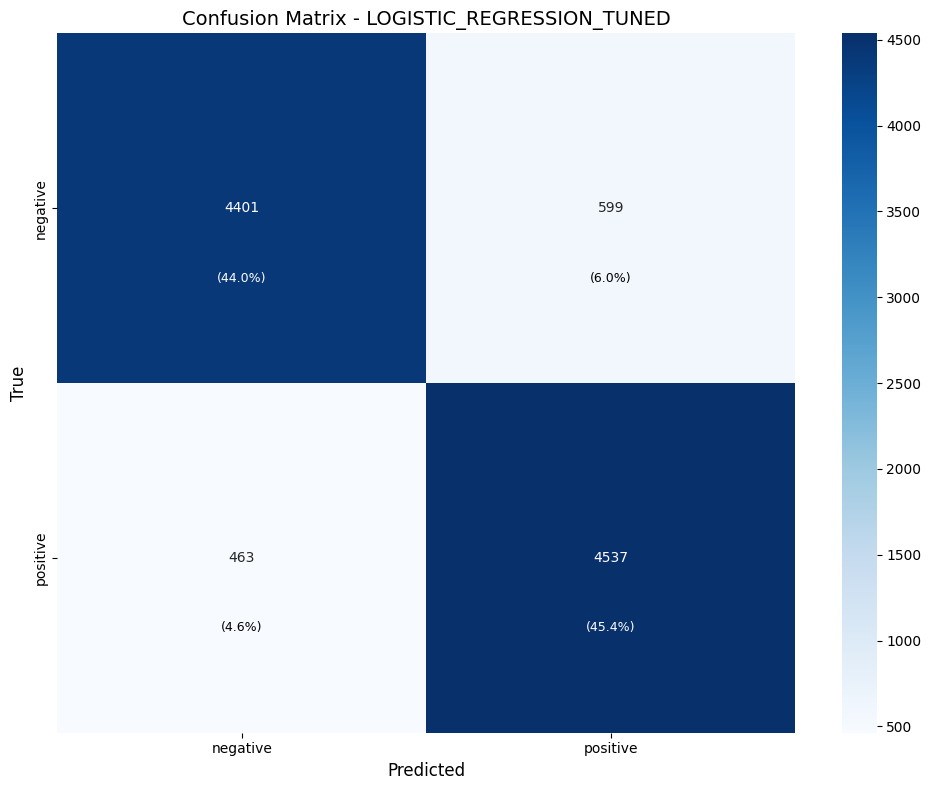

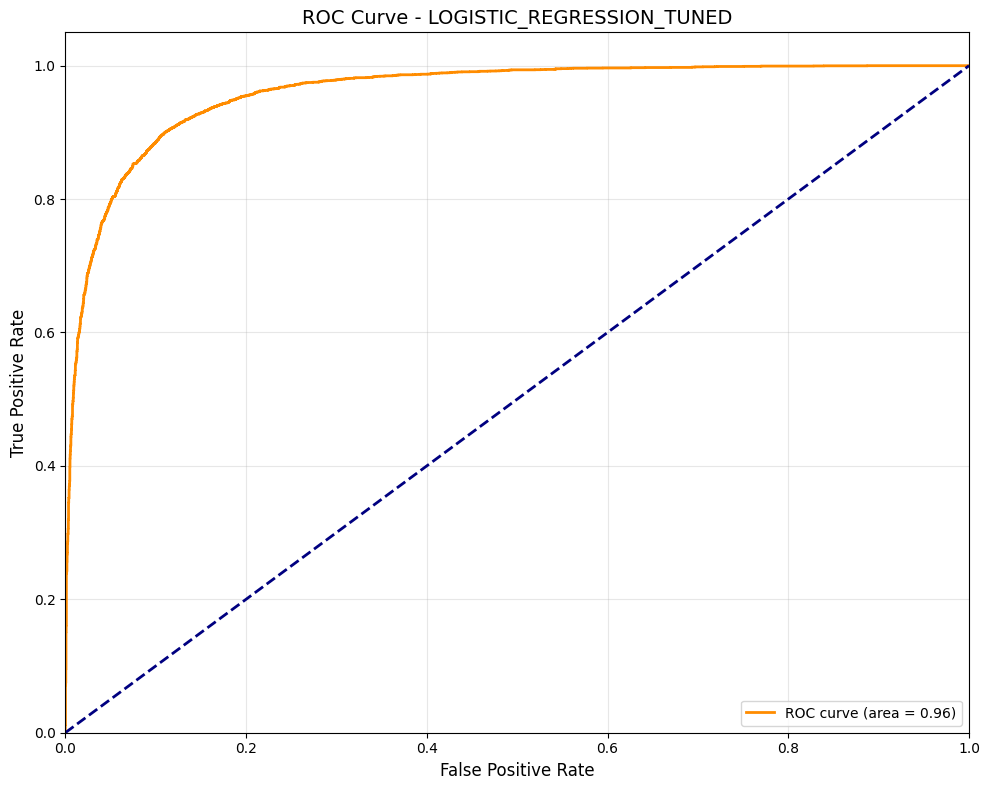

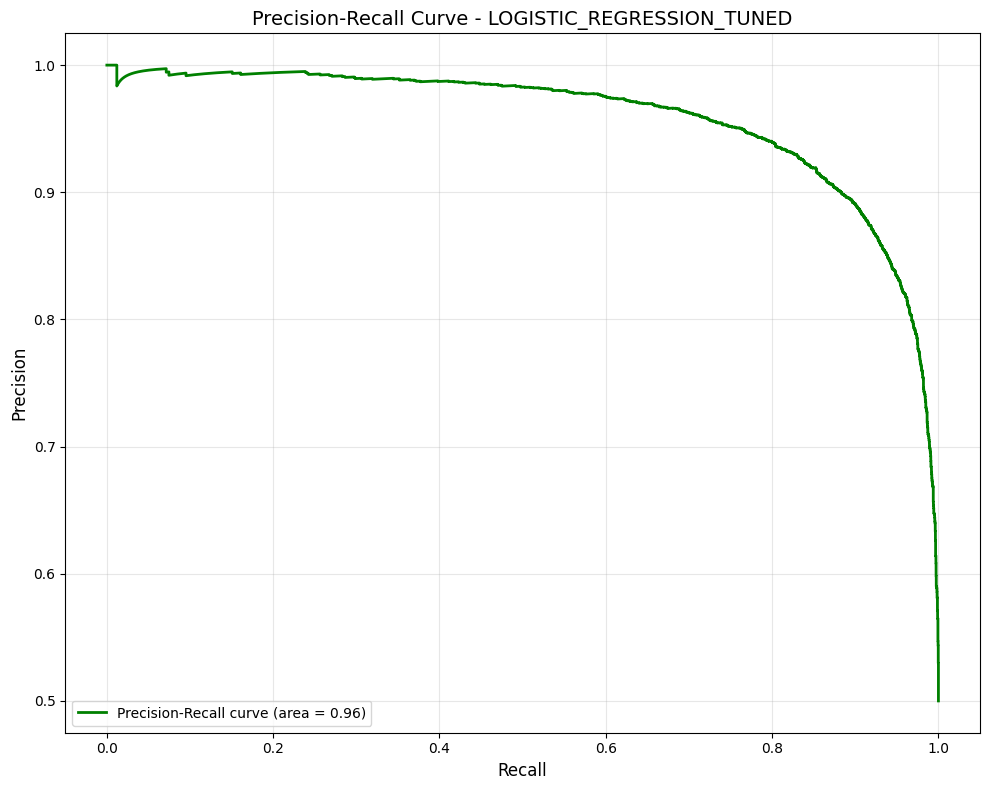

2025-05-27 23:15:59,191 - INFO - 
Misclassification Analysis for logistic_regression_tuned:
2025-05-27 23:15:59,192 - INFO - Total misclassified samples: 1062 (10.62%)
2025-05-27 23:15:59,195 - INFO - Class 'negative': 599/5000 misclassified (11.98%)
2025-05-27 23:15:59,196 - INFO - Class 'positive': 463/5000 misclassified (9.26%)
2025-05-27 23:15:59,196 - INFO - 
Performing hyperparameter tuning for Random Forest...
2025-05-27 23:15:59,197 - INFO - Performing hyperparameter tuning for random_forest...


Fitting 3 folds for each of 48 candidates, totalling 144 fits


2025-05-27 23:31:35,270 - INFO - Hyperparameter tuning completed in 936.07 seconds
2025-05-27 23:31:35,271 - INFO - Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
2025-05-27 23:31:35,271 - INFO - Best cross-validation score: 0.8540
2025-05-27 23:31:35,340 - WARNING - Could not visualize parameter importance for random_forest: '<' not supported between instances of 'int' and 'NoneType'
2025-05-27 23:31:35,341 - INFO - Tuned Random Forest - Best CV Score: 0.8540
2025-05-27 23:31:35,342 - INFO - Tuned Random Forest - Best Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
2025-05-27 23:31:35,342 - INFO - Evaluating random_forest_tuned model...
2025-05-27 23:31:37,247 - INFO - 
RANDOM_FOREST_TUNED Model Evaluation:
2025-05-27 23:31:37,248 - INFO - Accuracy: 0.8582
2025-05-27 23:31:37,248 - INFO - F1 Score: 0.8582
2025-05-27 23:31:37,

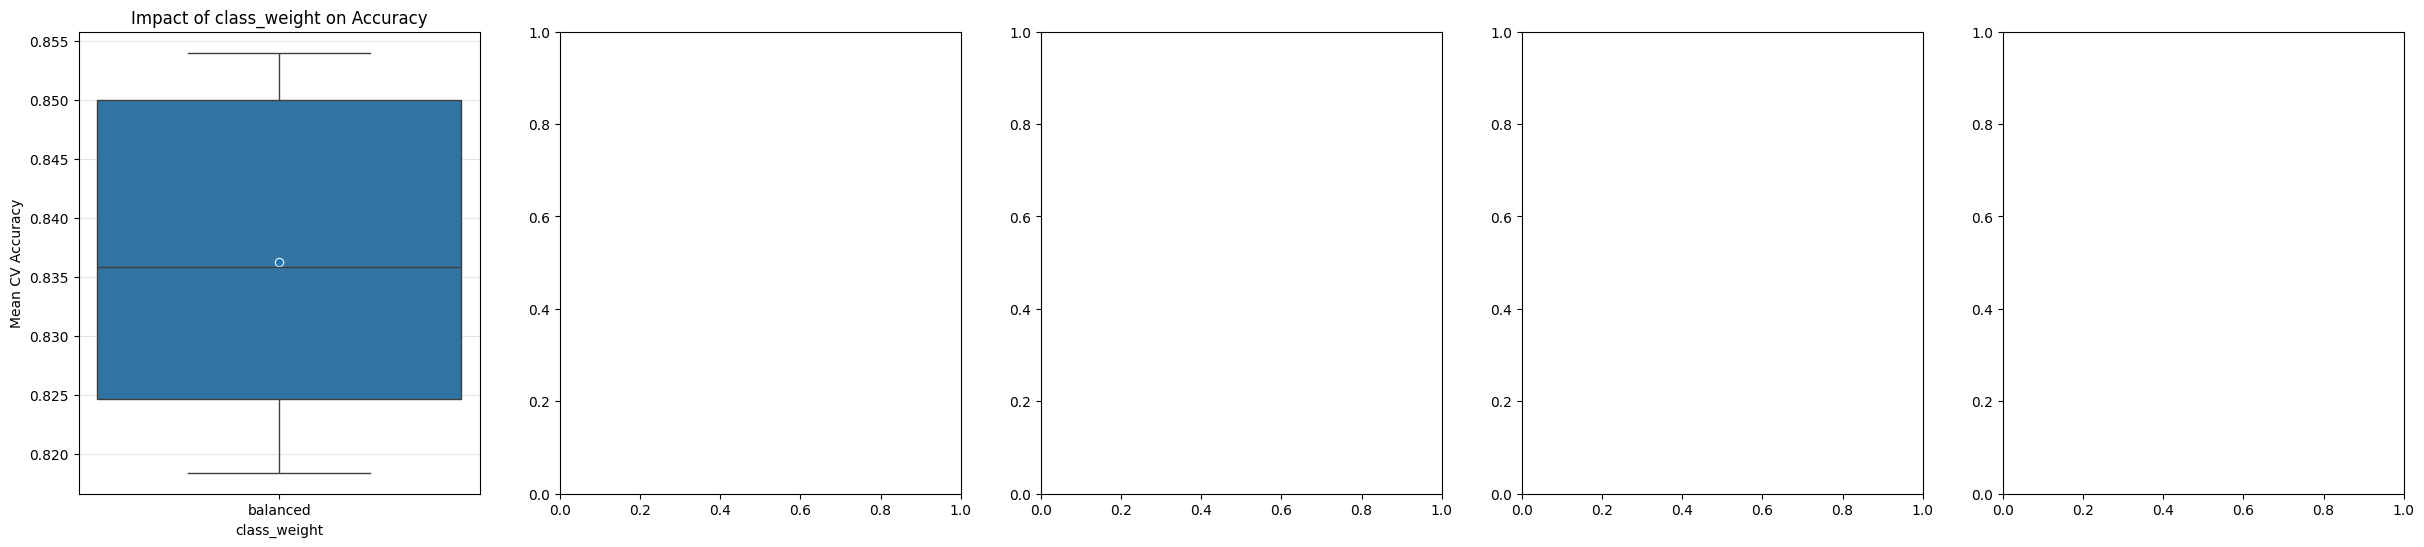

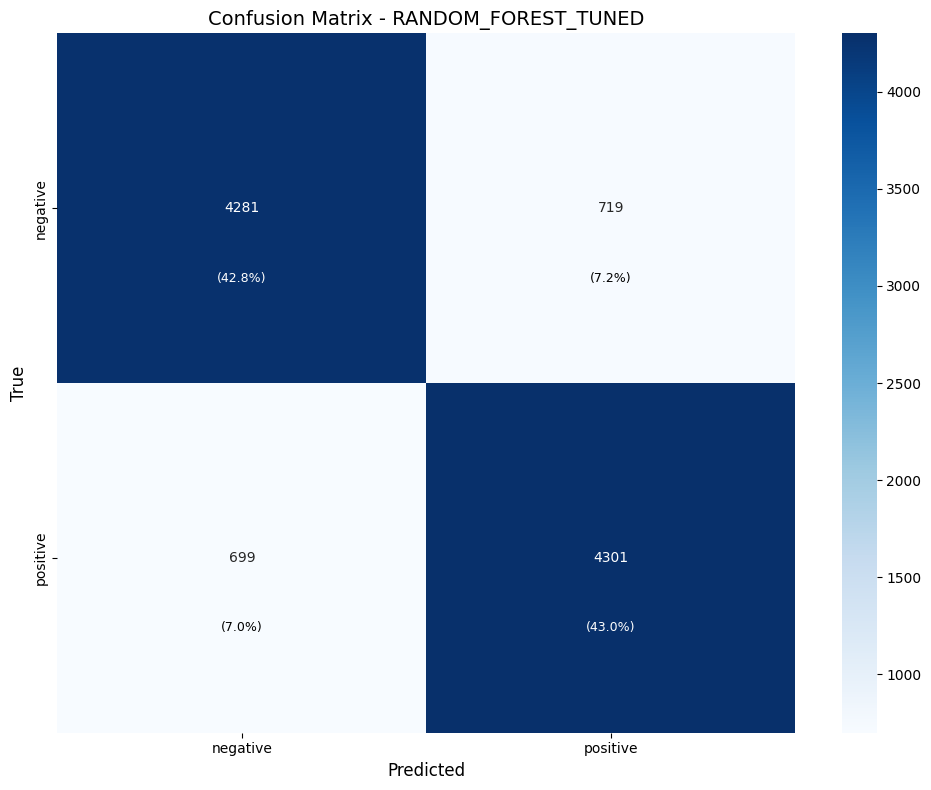

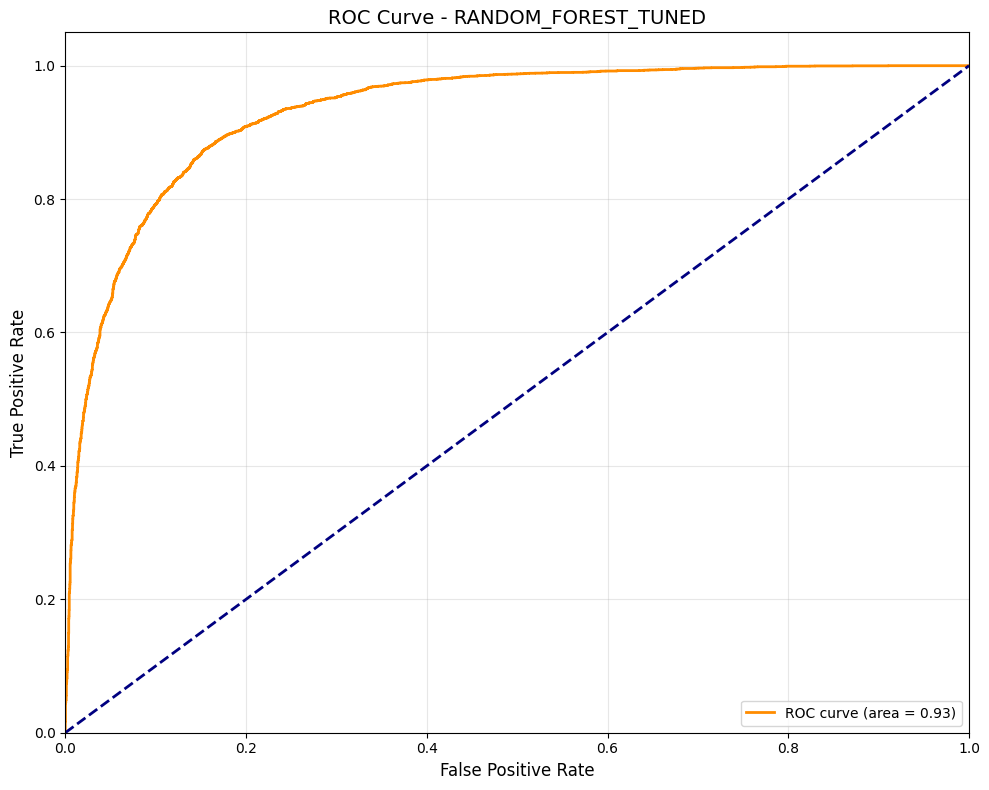

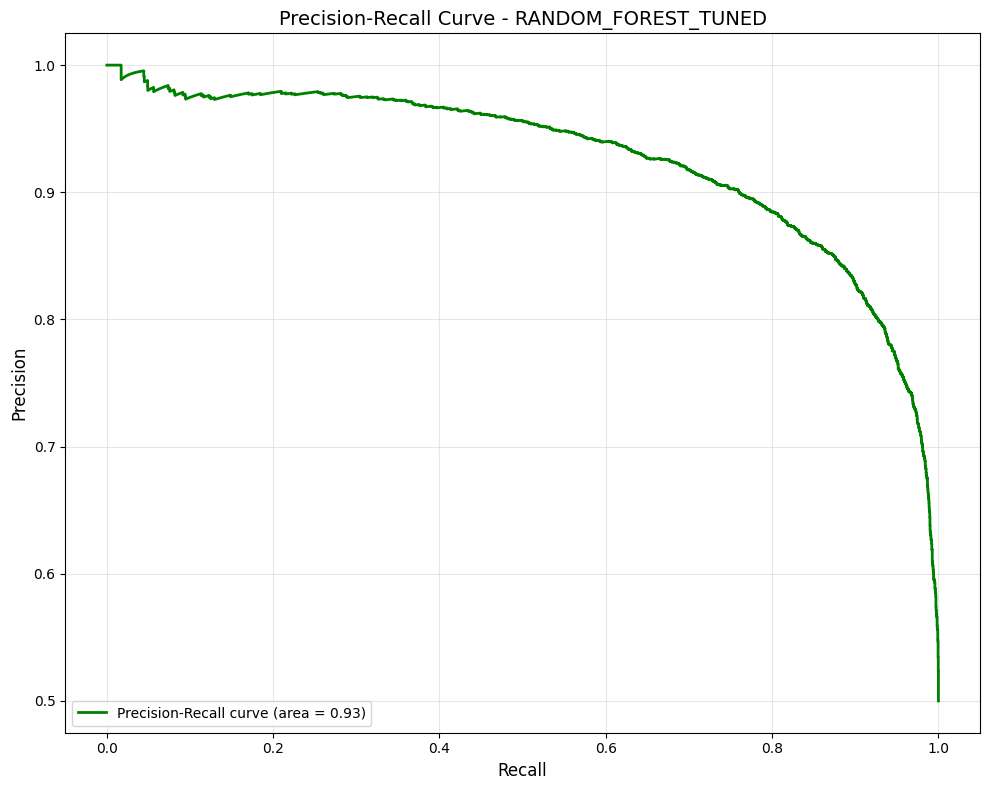

2025-05-27 23:31:37,868 - INFO - 
Misclassification Analysis for random_forest_tuned:
2025-05-27 23:31:37,869 - INFO - Total misclassified samples: 1418 (14.18%)
2025-05-27 23:31:37,872 - INFO - Class 'negative': 719/5000 misclassified (14.38%)
2025-05-27 23:31:37,872 - INFO - Class 'positive': 699/5000 misclassified (13.98%)
2025-05-27 23:31:37,873 - INFO - 
Performing hyperparameter tuning for SVM...
2025-05-27 23:31:37,874 - INFO - Performing hyperparameter tuning for svm...


Fitting 3 folds for each of 8 candidates, totalling 24 fits


2025-05-27 23:31:44,137 - INFO - Hyperparameter tuning completed in 6.26 seconds
2025-05-27 23:31:44,138 - INFO - Best parameters: {'C': 0.1, 'class_weight': None}
2025-05-27 23:31:44,139 - INFO - Best cross-validation score: 0.8922
2025-05-27 23:31:44,152 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-27 23:31:44,157 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


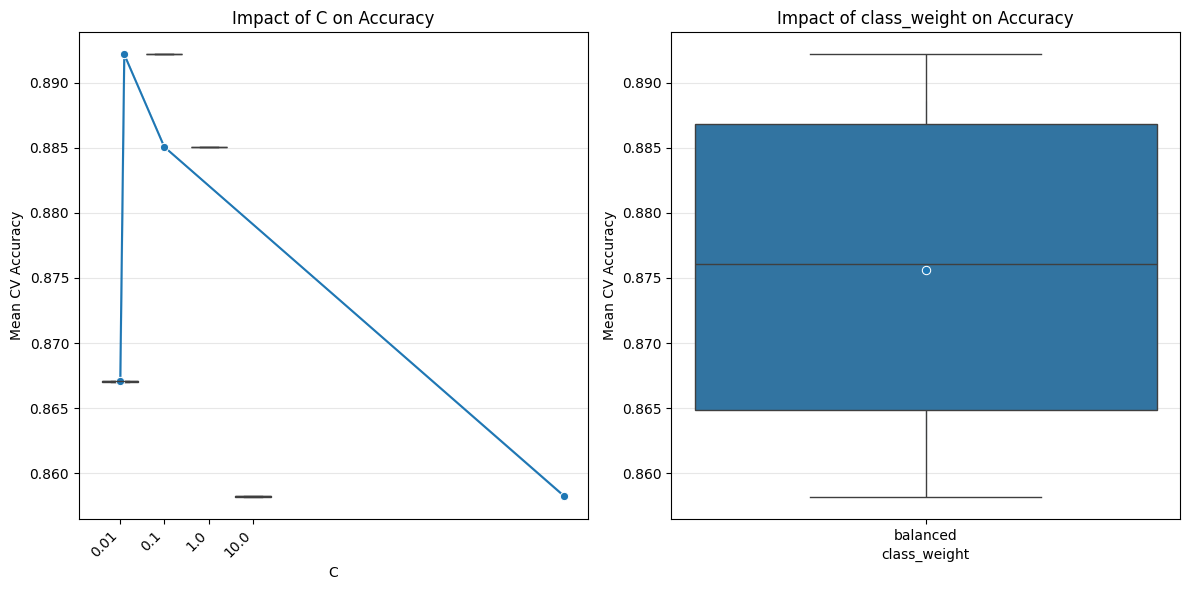

2025-05-27 23:31:44,401 - INFO - Tuned Logistic Regression - Best CV Score: 0.8922
2025-05-27 23:31:44,402 - INFO - Tuned Logistic Regression - Best Params: {'C': 0.1, 'class_weight': None}
2025-05-27 23:31:44,403 - INFO - Evaluating svm_tuned model...
2025-05-27 23:31:44,521 - INFO - 
SVM_TUNED Model Evaluation:
2025-05-27 23:31:44,522 - INFO - Accuracy: 0.8949
2025-05-27 23:31:44,522 - INFO - F1 Score: 0.8949
2025-05-27 23:31:44,523 - INFO - 
Classification Report:
2025-05-27 23:31:44,523 - INFO -               precision    recall  f1-score   support

    negative       0.91      0.88      0.89      5000
    positive       0.88      0.91      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



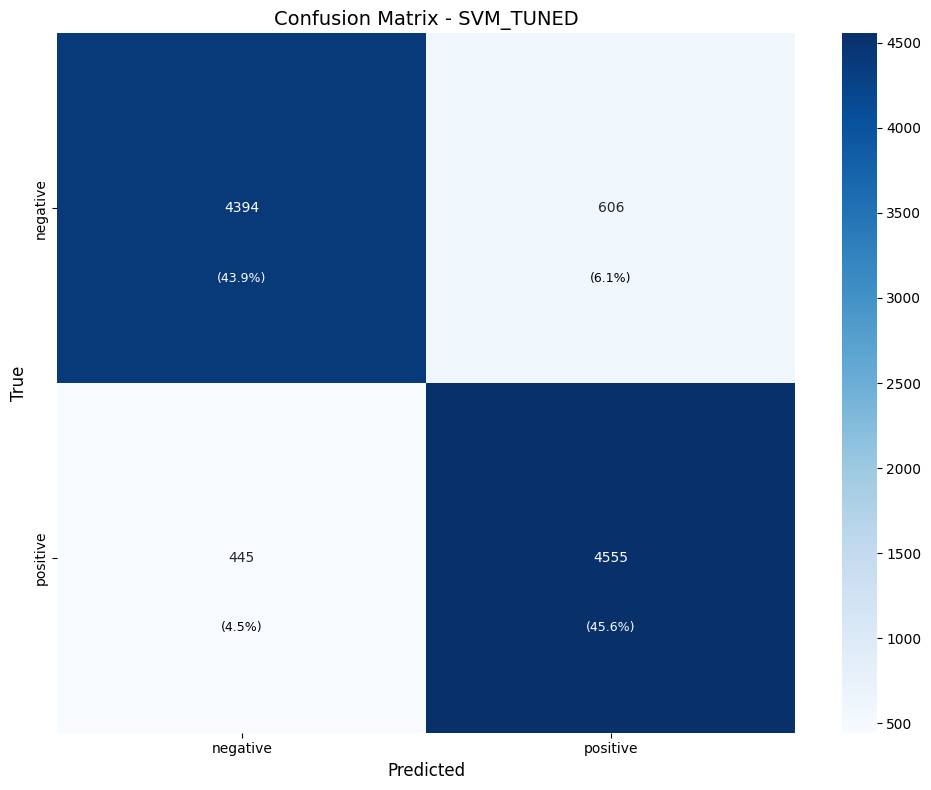

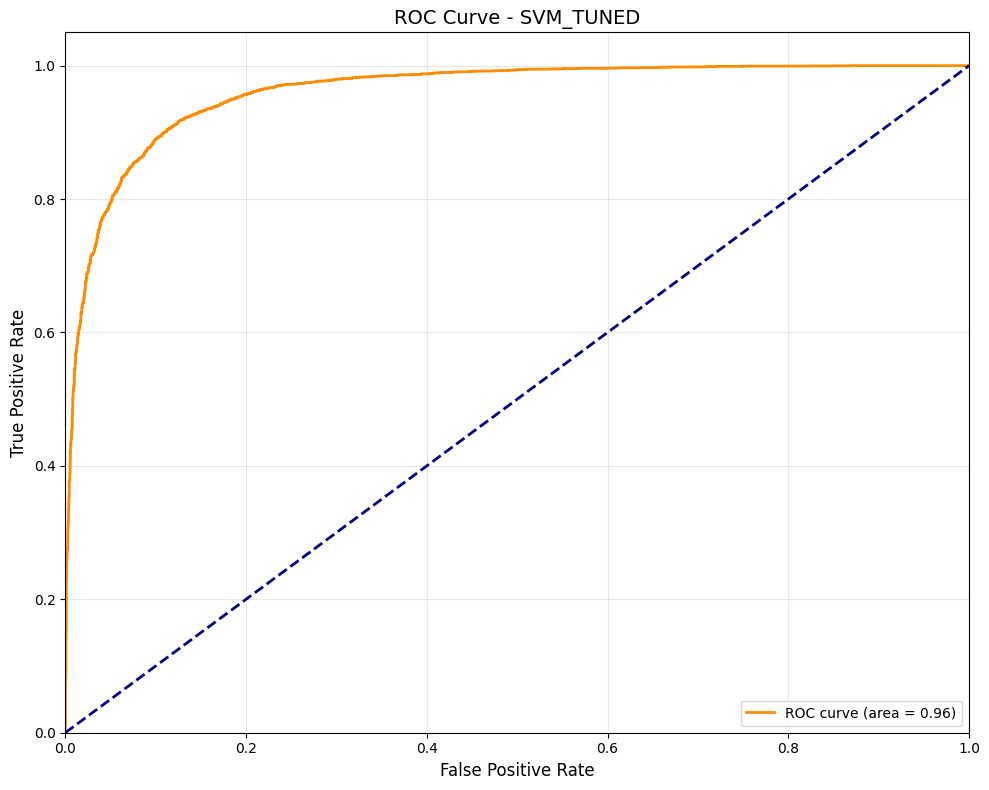

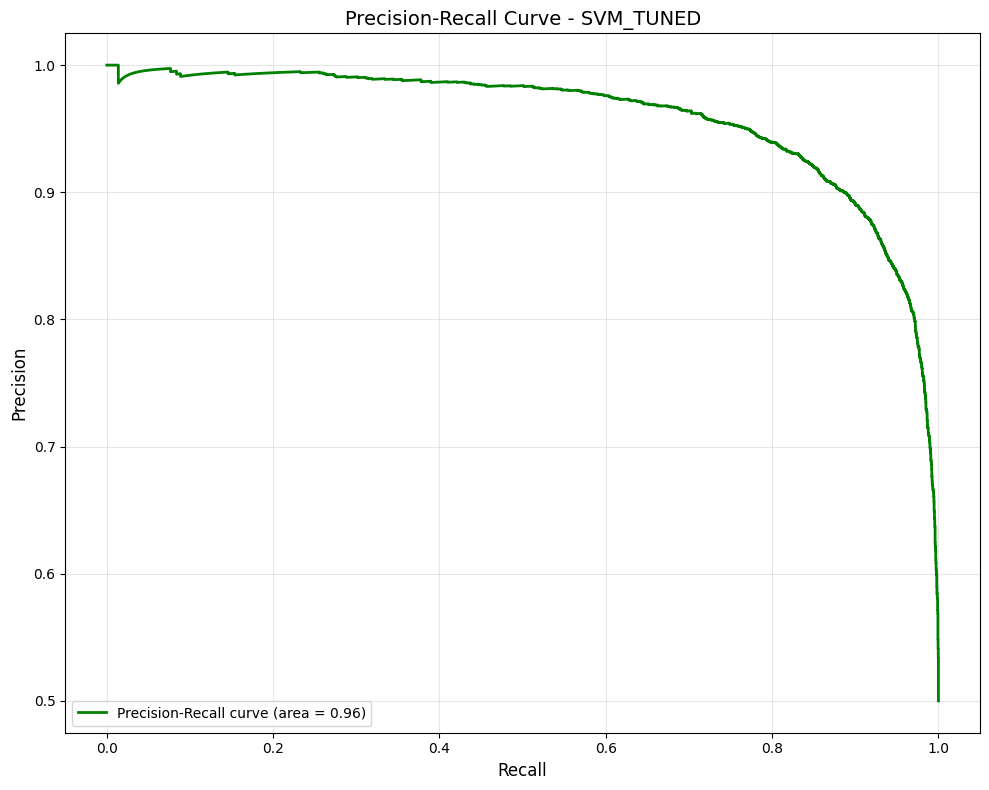

2025-05-27 23:31:44,918 - INFO - 
Misclassification Analysis for svm_tuned:
2025-05-27 23:31:44,919 - INFO - Total misclassified samples: 1051 (10.51%)
2025-05-27 23:31:44,921 - INFO - Class 'negative': 606/5000 misclassified (12.12%)
2025-05-27 23:31:44,922 - INFO - Class 'positive': 445/5000 misclassified (8.90%)
2025-05-27 23:31:44,923 - INFO - 
Performing hyperparameter tuning for Naive Bayes...
2025-05-27 23:31:44,923 - INFO - Performing hyperparameter tuning for naive_bayes...


Fitting 3 folds for each of 8 candidates, totalling 24 fits


2025-05-27 23:31:45,675 - INFO - Hyperparameter tuning completed in 0.75 seconds
2025-05-27 23:31:45,676 - INFO - Best parameters: {'alpha': 1.0, 'fit_prior': True}
2025-05-27 23:31:45,676 - INFO - Best cross-validation score: 0.8678
2025-05-27 23:31:45,689 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-27 23:31:45,693 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


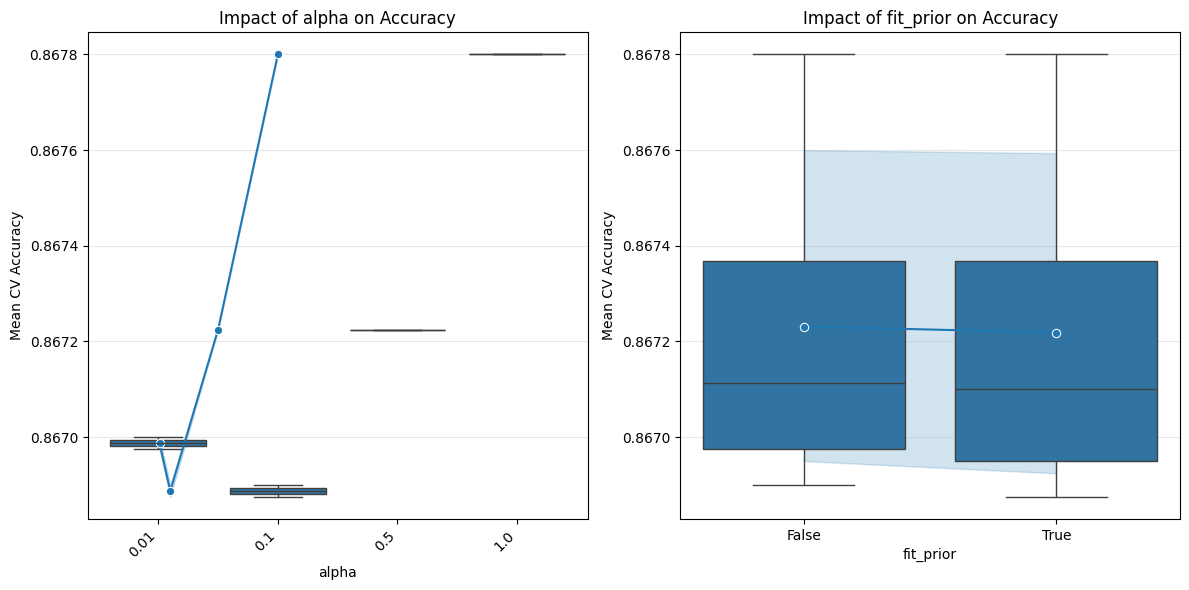

2025-05-27 23:31:45,965 - INFO - Tuned Naive Bayes - Best CV Score: 0.8678
2025-05-27 23:31:45,966 - INFO - Tuned Naive Bayes - Best Params: {'alpha': 1.0, 'fit_prior': True}
2025-05-27 23:31:45,967 - INFO - Evaluating naive_bayes_tuned model...
2025-05-27 23:31:46,089 - INFO - 
NAIVE_BAYES_TUNED Model Evaluation:
2025-05-27 23:31:46,090 - INFO - Accuracy: 0.8678
2025-05-27 23:31:46,090 - INFO - F1 Score: 0.8678
2025-05-27 23:31:46,091 - INFO - 
Classification Report:
2025-05-27 23:31:46,091 - INFO -               precision    recall  f1-score   support

    negative       0.88      0.85      0.87      5000
    positive       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



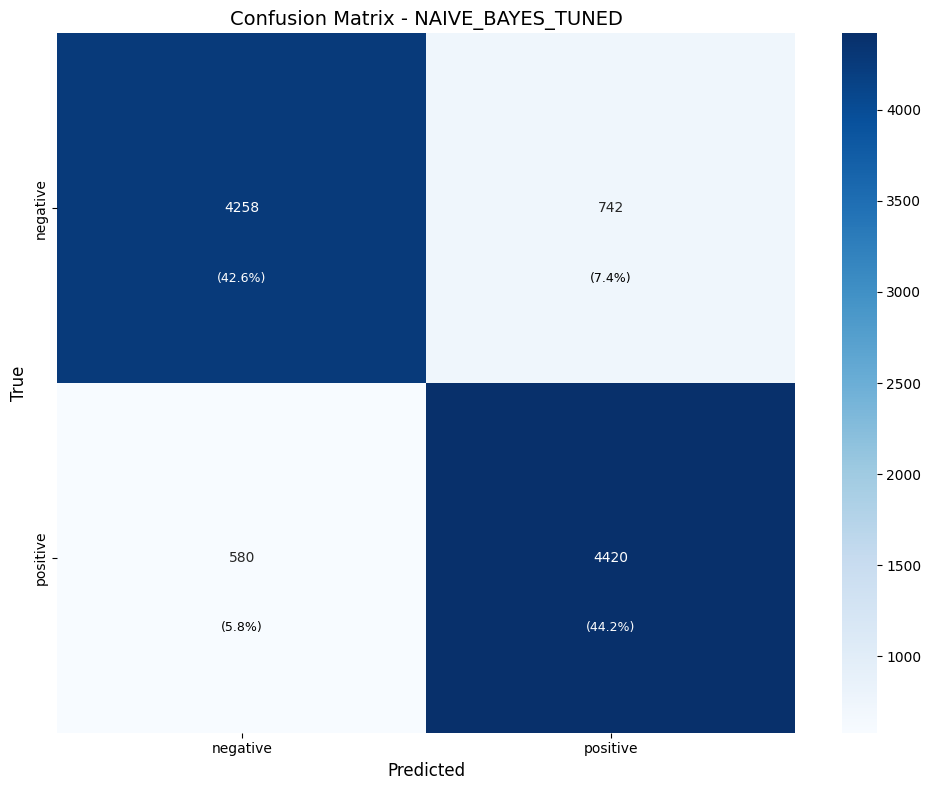

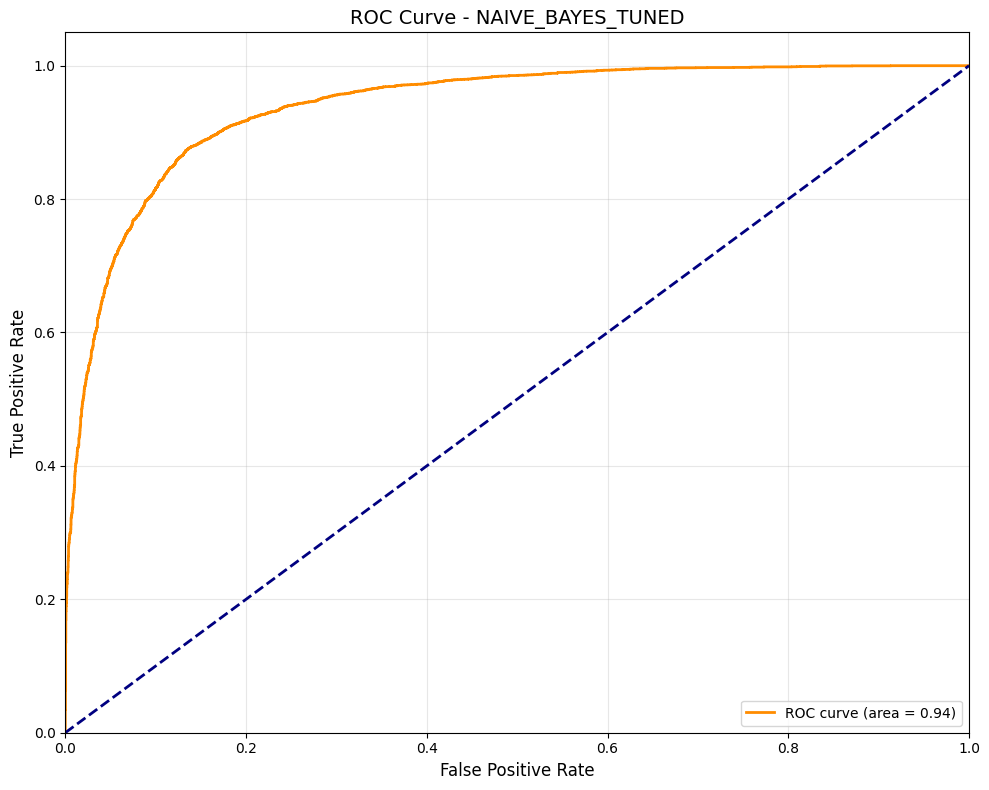

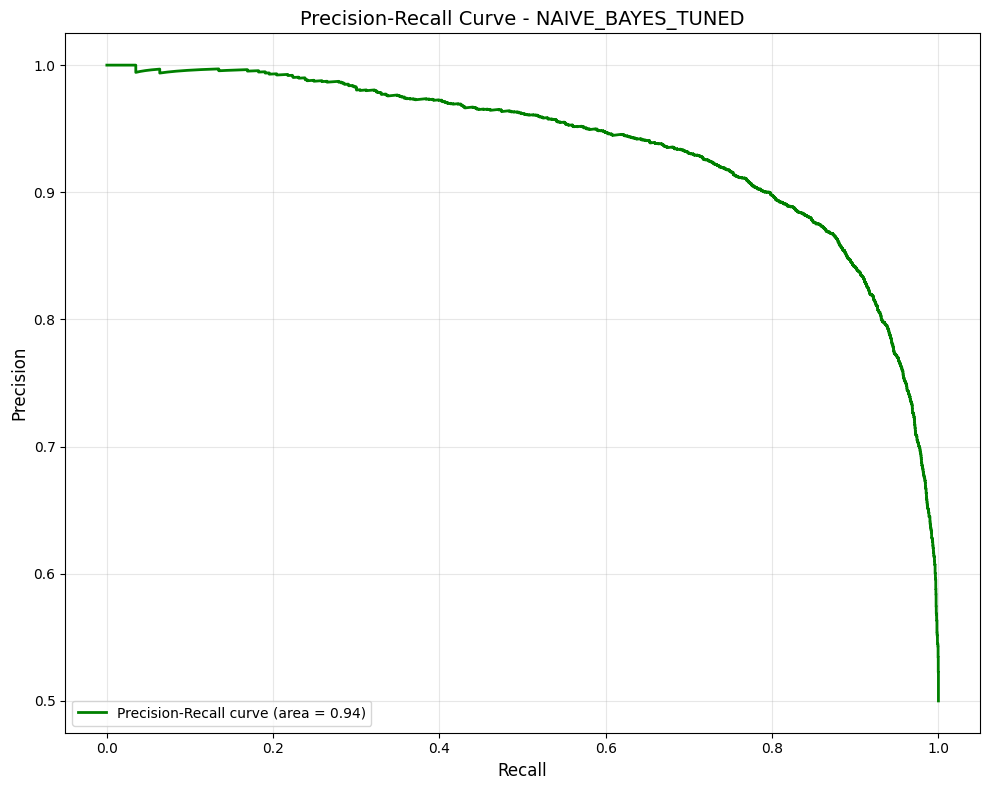

2025-05-27 23:31:46,482 - INFO - 
Misclassification Analysis for naive_bayes_tuned:
2025-05-27 23:31:46,483 - INFO - Total misclassified samples: 1322 (13.22%)
2025-05-27 23:31:46,485 - INFO - Class 'negative': 742/5000 misclassified (14.84%)
2025-05-27 23:31:46,486 - INFO - Class 'positive': 580/5000 misclassified (11.60%)


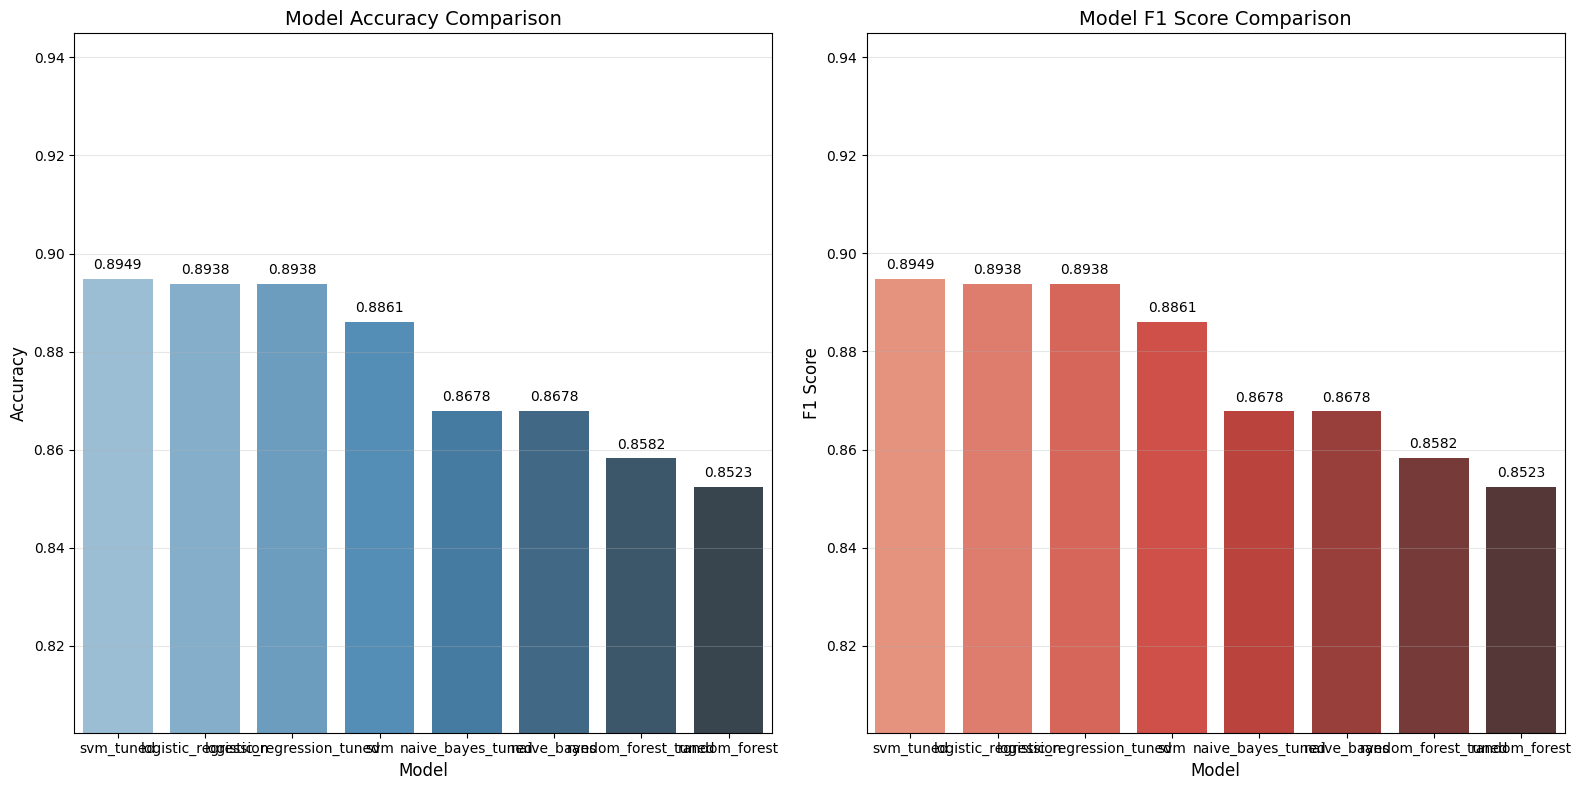

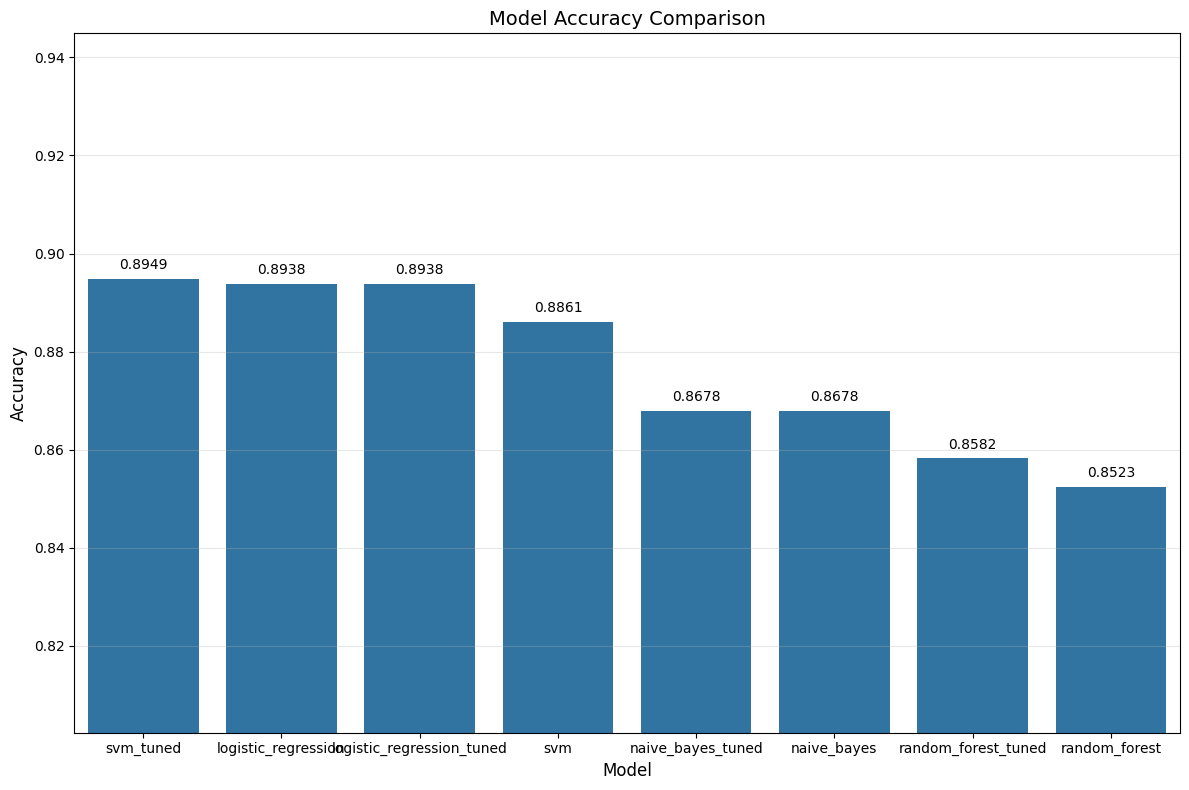

2025-05-27 23:31:47,276 - INFO - 
Best model: svm_tuned
2025-05-27 23:31:47,277 - INFO -   Accuracy: 0.8949
2025-05-27 23:31:47,277 - INFO -   F1 Score: 0.8949


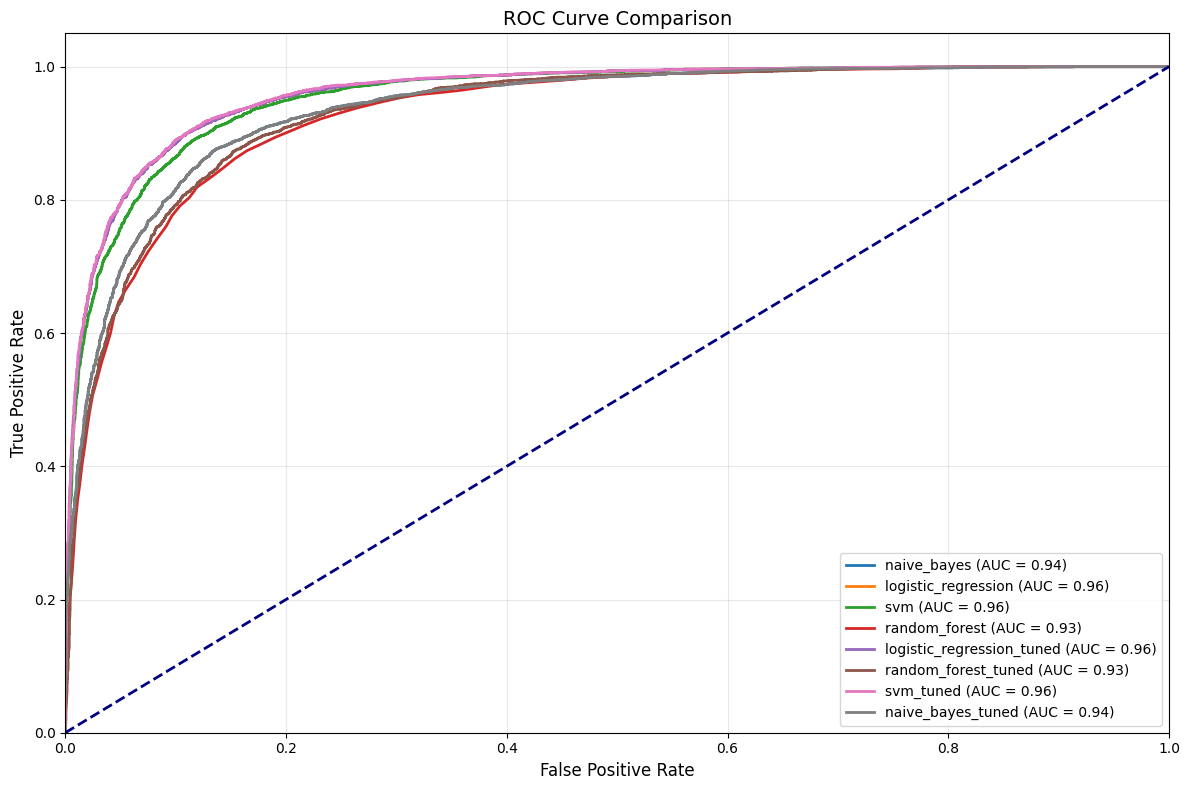

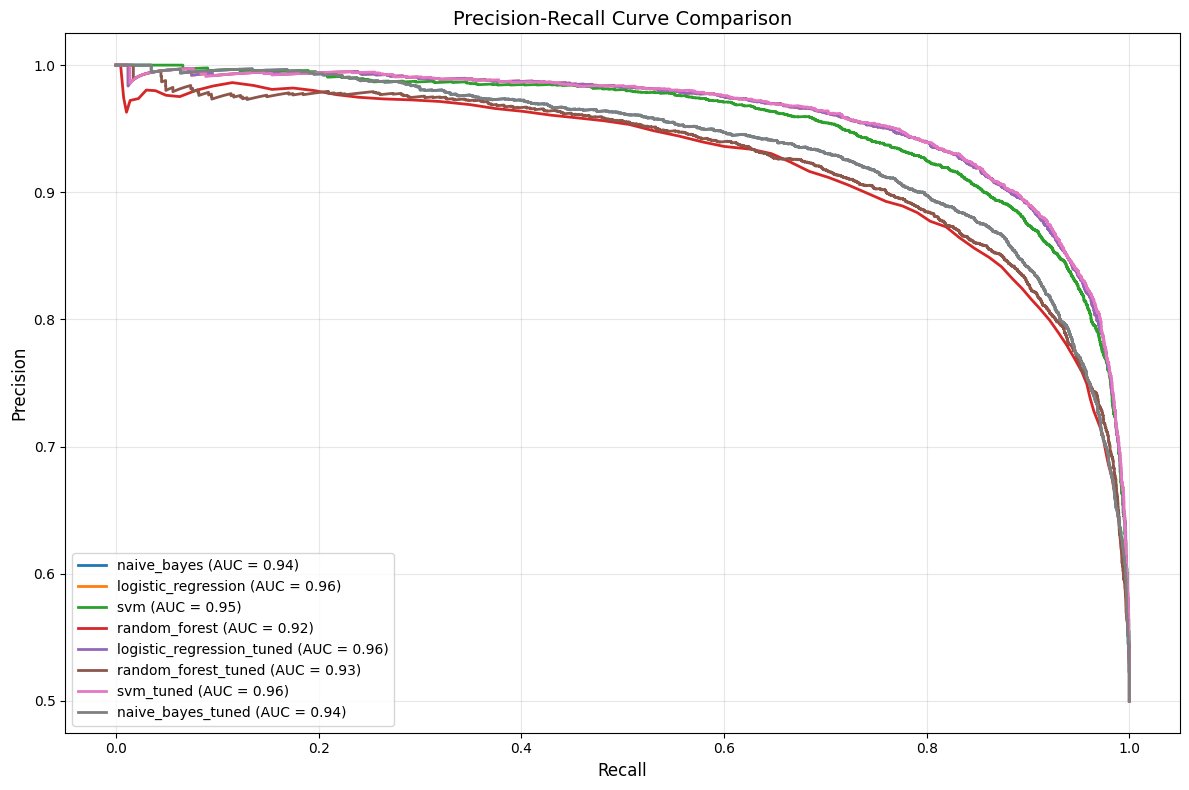

2025-05-27 23:31:47,651 - INFO - 
Making predictions on example reviews...
2025-05-27 23:31:47,661 - INFO - 
Example predictions:
2025-05-27 23:31:47,661 - INFO - 
Example 1: This movie was absolutely fantastic! The acting was superb and the plot was engaging....
Prediction: positive (Confidence/Score: 0.6816)
2025-05-27 23:31:47,662 - INFO - 
Example 2: What a terrible film. I wasted two hours of my life. Avoid at all costs....
Prediction: negative (Confidence/Score: 0.8422)
2025-05-27 23:31:47,663 - INFO - 
Example 3: It was an okay movie, not great but not bad either. Some good scenes....
Prediction: negative (Confidence/Score: 0.6174)
2025-05-27 23:31:47,663 - INFO - 
Example 4: I'm not sure how I feel about this one. It had its moments, but overall, pretty confusing....
Prediction: negative (Confidence/Score: 0.5547)
2025-05-27 23:31:47,663 - INFO - Example predictions completed and logged.
2025-05-27 23:31:47,664 - INFO - 
Sentiment analysis pipeline completed in 2468.03 seconds.

In [4]:
def main():
    """Main execution function."""
    main_start_time = time.time()

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    setup_nltk()

    data_prep = DataPreparation(CSV_FILE_PATH)

    logger.info("Loading and analyzing dataset...")
    df = data_prep.load_data()

    #temp line for testing
    sampled_df = df.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(min(len(x), int(SAMPLE_SIZE/2)), random_state=42)
    ).reset_index(drop=True)
    data_prep.df = sampled_df
    df = sampled_df  # optional: if you use `df` later directly

    if df.empty:
        logger.error("DataFrame is empty after loading. Exiting.")
        return
    df = data_prep.analyze_dataset()

    logger.info("\nPreprocessing data...")
    df = data_prep.preprocess_data(remove_stopwords=True, stemming=False, lemmatization=True)

    if 'processed_review' not in df.columns or df['processed_review'].isnull().all():
        logger.error("Preprocessing failed or resulted in empty reviews. Exiting.")
        return

    data_prep.compare_sentiment_vocabulary()

    # change the sample size as you wish from the beginning of the file, 50000 is the maximum
    is_sample = df.shape[0] <= SAMPLE_SIZE

    model_trainer = SentimentModelTrainer(OUTPUT_DIR)

    if is_sample:
        logger.info("\nWorking with sample data. Using cross-validation.")

        if 'processed_review' not in df.columns or 'sentiment' not in df.columns:
            logger.error("Required columns ('processed_review', 'sentiment') not in DataFrame. Exiting.")
            return

        X = df['processed_review']
        y = df['sentiment']

        if X.empty or y.empty:
             logger.error("Feature (X) or target (y) data is empty for sample. Exiting.")
             return

        logger.info("\nExtracting features for cross-validation...")
        X_tfidf, _, tfidf_vectorizer = model_trainer.extract_features(X, pd.Series([], dtype=str), 'tfidf')
        if X_tfidf is None:
            logger.error("Feature extraction failed for sample data. Exiting.")
            return

        model_trainer.best_vectorizer = tfidf_vectorizer

        model_trainer.cross_validate_models(X_tfidf, y, cv=min(5, df['sentiment'].value_counts().min()))
        logger.info("\nSplitting data into train and test sets...")
        X_train, X_test, y_train, y_test = data_prep.split_data(test_size=0.2)

        if X_train is None or X_test is None or y_train is None or y_test is None or \
           X_train.empty or X_test.empty or y_train.empty or y_test.empty:
            logger.error("Data splitting resulted in empty sets. Exiting.")
            return

        logger.info("\nExtracting features...")
        X_train_tfidf, X_test_tfidf, tfidf_vectorizer = model_trainer.extract_features(X_train, X_test, 'tfidf')
        if X_train_tfidf is None or X_test_tfidf is None:
            logger.error("Feature extraction failed for train/test data. Exiting.")
            return

        model_trainer.best_vectorizer = tfidf_vectorizer

        logger.info("\nTraining and evaluating models...")

        model_trainer.train_model(X_train_tfidf, y_train, 'naive_bayes')
        model_trainer.evaluate_model(model_trainer.models.get('naive_bayes'), X_test_tfidf, y_test, 'naive_bayes')

        model_trainer.train_model(X_train_tfidf, y_train, 'logistic_regression', C=1.0)
        model_trainer.evaluate_model(model_trainer.models.get('logistic_regression'), X_test_tfidf, y_test, 'logistic_regression')

        model_trainer.train_model(X_train_tfidf, y_train, 'svm', C=1.0)
        model_trainer.evaluate_model(model_trainer.models.get('svm'), X_test_tfidf, y_test, 'svm')

        model_trainer.train_model(X_train_tfidf, y_train, 'random_forest', n_estimators=100)
        model_trainer.evaluate_model(model_trainer.models.get('random_forest'), X_test_tfidf, y_test, 'random_forest')

        # hyperparameter tuning for Logistic Regression

        logger.info("\nPerforming hyperparameter tuning for Logistic Regression...")

        lr_param_grid_refined = {'C': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0], 'penalty': ['l2'], 'solver': ['liblinear','lbfgs','saga'], 'class_weight': [None, 'balanced']}

        tuned_lr_model, best_lr_params, best_lr_score = model_trainer.hyperparameter_tuning(
            X_train_tfidf, y_train, 'logistic_regression', lr_param_grid_refined, cv=3
        )
        if tuned_lr_model:
            logger.info(f"Tuned Logistic Regression - Best CV Score: {best_lr_score:.4f}")
            logger.info(f"Tuned Logistic Regression - Best Params: {best_lr_params}")
            model_trainer.models['logistic_regression_tuned'] = tuned_lr_model
            model_trainer.evaluate_model(tuned_lr_model, X_test_tfidf, y_test, 'logistic_regression_tuned')

        # hyperparameter tuning for Random Forest

        logger.info("\nPerforming hyperparameter tuning for Random Forest...")
        rf_param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'class_weight': [None, 'balanced']
        }
        tuned_rf_model, best_rf_params, best_rf_score = model_trainer.hyperparameter_tuning(
            X_train_tfidf, y_train, 'random_forest', rf_param_grid, cv=3
        )
        if tuned_rf_model:
            logger.info(f"Tuned Random Forest - Best CV Score: {best_rf_score:.4f}")
            logger.info(f"Tuned Random Forest - Best Params: {best_rf_params}")
            model_trainer.models['random_forest_tuned'] = tuned_rf_model
            model_trainer.evaluate_model(tuned_rf_model, X_test_tfidf, y_test, 'random_forest_tuned')

        # hyperparameter tuning for SVM

        logger.info("\nPerforming hyperparameter tuning for SVM...")
        svm_param_grid = {
            'C': [0.01, 0.1, 1.0, 10.0],
            'class_weight': [None, 'balanced'],
            # 'penalty': ['l2'], # penalty is always l2 for LinearSVC
            # 'loss': ['squared_hinge'], # default, optional
        }
        tuned_svm_model, best_svm_params, best_svm_score = model_trainer.hyperparameter_tuning(
            X_train_tfidf, y_train, 'svm', svm_param_grid, cv=3
        )
        if tuned_svm_model:
            logger.info(f"Tuned Logistic Regression - Best CV Score: {best_svm_score:.4f}")
            logger.info(f"Tuned Logistic Regression - Best Params: {best_svm_params}")
            model_trainer.models['svm_tuned'] = tuned_svm_model
            model_trainer.evaluate_model(tuned_svm_model, X_test_tfidf, y_test, 'svm_tuned')

        # hyperparameter tuning for Naive Bayes
        logger.info("\nPerforming hyperparameter tuning for Naive Bayes...")
        nb_param_grid = {
            'alpha': [0.01, 0.1, 0.5, 1.0],
            'fit_prior': [True, False]
        }
        tuned_nb_model, best_nb_params, best_nb_score = model_trainer.hyperparameter_tuning(
            X_train_tfidf, y_train, 'naive_bayes', nb_param_grid, cv=3
        )
        if tuned_nb_model:
            logger.info(f"Tuned Naive Bayes - Best CV Score: {best_nb_score:.4f}")
            logger.info(f"Tuned Naive Bayes - Best Params: {best_nb_params}")
            model_trainer.models['naive_bayes_tuned'] = tuned_nb_model
            model_trainer.evaluate_model(tuned_nb_model, X_test_tfidf, y_test, 'naive_bayes_tuned')

        model_trainer.compare_models()

    example_reviews = [
        "This movie was absolutely fantastic! The acting was superb and the plot was engaging.",
        "What a terrible film. I wasted two hours of my life. Avoid at all costs.",
        "It was an okay movie, not great but not bad either. Some good scenes.",
        "I'm not sure how I feel about this one. It had its moments, but overall, pretty confusing."
    ]

    if model_trainer.best_model and model_trainer.best_vectorizer:
        logger.info("\nMaking predictions on example reviews...")
        prediction_results = model_trainer.predict_examples(
            example_reviews,
            vectorizer=model_trainer.best_vectorizer
        )
        if prediction_results:
            logger.info("Example predictions completed and logged.")
    else:
        logger.warning("Best model or vectorizer not available, skipping example predictions.")

    total_execution_time = time.time() - main_start_time
    logger.info(f"\nSentiment analysis pipeline completed in {total_execution_time:.2f} seconds.")
    logger.info(f"All results and logs saved to directory: {os.path.abspath(OUTPUT_DIR)}")

if __name__ == '__main__':
    main()